In [1]:
import os
import sys
import time
import itertools
import numpy as np

# Torch
import torch
from torch import nn
import torch.optim as optim
from torch.autograd import Variable
print("Torch Version:", torch.__version__)

sys.path.append("../../")

# Planning
sys.path.append("../Planning/")
import Planners as Planners

# Control
sys.path.append("../Acting/")
import TrajectorySamplers as TrajectorySamplers

# Model
sys.path.append("../Learning/")
import Models as Models
from Models import weights_init

# Simple RL
from simple_rl.tasks import NavigationWorldMDP
from simple_rl.tasks.navigation.NavigationWorldMDP import NavigationWorldMDP, generate_states, NavigationWorldState

# IRL
sys.path.append("../MLIRL")
from MLIRL import MLIRL

# MaxEnt
sys.path.append("../MaxEntIRL")
from MaxEntIRL import *

# Eval
sys.path.append("../utils/")
from Evaluation import *

from helper import convert_to_grid, plot_irl_gridworld, plot_irl_results

import matplotlib.pyplot as plt
import matplotlib.style as style
from mpl_toolkits.axes_grid1 import make_axes_locatable
# style.use('classic')
%matplotlib inline

import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D

mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['axes.grid'] = False
mpl.rcParams['image.interpolation'] = 'nearest'
mpl.rcParams['figure.figsize'] = 15, 55

%matplotlib inline
%load_ext autoreload
%autoreload 2


Torch Version: 0.5.0a0+ab6afc2


# Expert Demonstrations

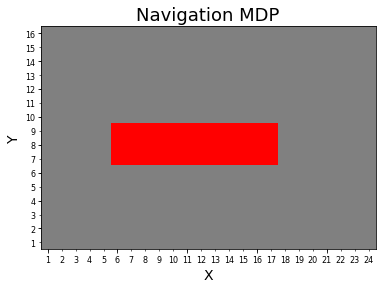

(<Figure size 432x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x126953ba8>)

In [2]:
def shortest_path_fn(s, g, nvmdp, living_reward=-0.01):
    
    R_s = nvmdp._reward_func_state_only
    T = nvmdp.transition_func
    A = nvmdp.get_actions()
    return Planners.astar_find_path(
        s, g, A, T, cost_fn=lambda s: -R_s(s),
        heuristic_fn=lambda s1, s2: (living_reward) * np.linalg.norm(np.array(s1) - np.array(s2)))

np.random.seed(1)
torch.manual_seed(1)
W, H = 24,16
obstacle = lambda x, y, w, h: [(x+i, y+j) for j in range(h) for i in range(w)]
state_cells = list(itertools.chain(*[o() for o in generate_states(
                              W, H, n_states=1, 
                              obstacle_w_mu=W, obstacle_w_std=0.0, 
                              obstacle_h_mu=H, obstacle_h_std=0.0,
                              buffer_w=0, buffer_h=0, max_search_tries=1)]))
traj_with_temperature = True
nvmdp_real = NavigationWorldMDP(
    
    width = W, height = H,
    nav_cell_types = ["gray", "red"],
    nav_cell_rewards = [-0.01, -10], # To create separate indicator feature for each obstacle cell.
    nav_cell_p_or_locs = [1., obstacle(6,7,12,3)],
#     nav_cell_types = ["gray"],
#     nav_cell_rewards = [-0.01], # To create separate indicator feature for each obstacle cell.
#     nav_cell_p_or_locs = [1.],
    goal_cell_types = [],
    goal_cell_rewards = [],
    goal_cell_locs = [],
    slip_prob = 0.0, step_cost = 0,
    gamma = 0.95
)

nvmdp_real.visualize_grid()

In [3]:
"""
Shortest Paths
"""
start, goal = NavigationWorldState(5,8), NavigationWorldState(20,8)
if not traj_with_temperature:
    trajectories = TrajectorySamplers.sample_shortest_path_trajectories(
        [NavigationWorldState(2,6), NavigationWorldState(2,8)], [NavigationWorldState(10,6), NavigationWorldState(10,7)], 
        lambda s,g,mdp=nvmdp_real: shortest_path_fn(s,g,mdp))
    trajectories_states = [list(zip(*traj))[0] for traj in trajectories]
else:
    
    EXPERT_TEMP = 0.1
    N_TRAJ = 2
    S = nvmdp_real.get_all_states()
    s_to_idx = {v:k for k,v in enumerate(S)}
    A = nvmdp_real.get_actions()
    T = nvmdp_real.transition_func
    R_real_s = nvmdp_real._reward_func_state_only
    R_real = torch.tensor([float(R_real_s(s)) for s in S], requires_grad=True)
    policy = lambda Q, temp=EXPERT_TEMP: Planners.log_boltzmann_dist(Q, temp)
    log_Pi, V, Q, s_to_idx, a_to_idx, iterno = Planners.value_iteration(
        S, A, R_real, lambda s,a: [(T(s,a), 1.)], policy, 0.99, 200, start, goal)

    trajectories = TrajectorySamplers.sample_trajectories(N_TRAJ, S, A, T, [start]*N_TRAJ, log_Pi.detach().numpy(),
                                         goal, greedy_selection=False, values=V)
    trajectories_states = [list(zip(*traj))[0] for traj in trajectories]

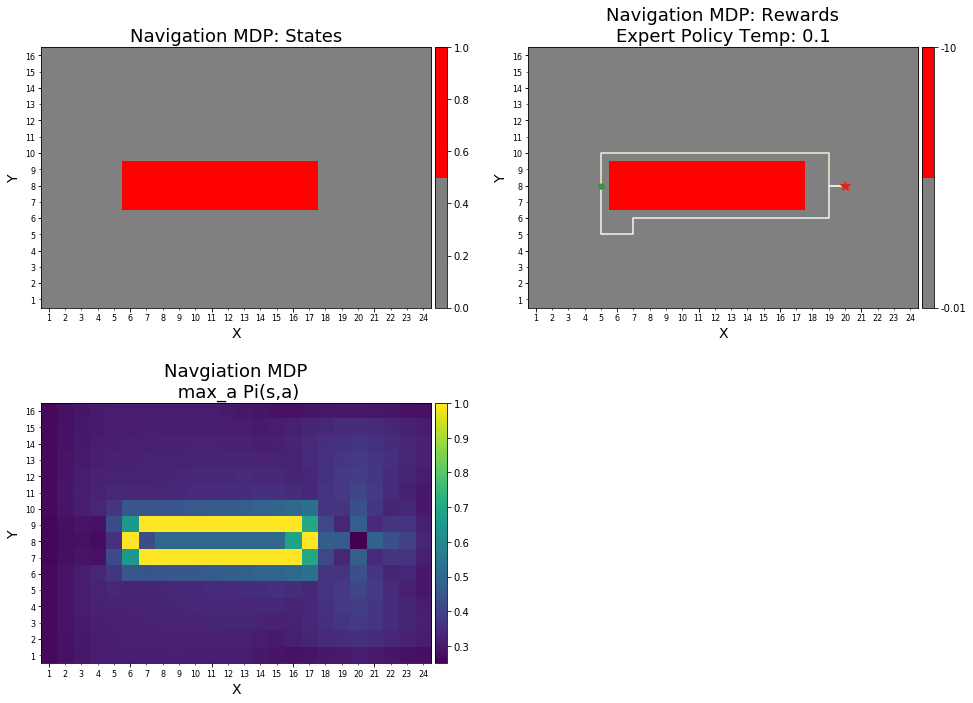

In [4]:
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(221)
fig, ax = nvmdp_real.visualize_grid(fig=fig, ax=ax, 
                                    show_colorbar=True, end_marker="*", 
                                    subplot_str="121", title="Navigation MDP: States")
ax = fig.add_subplot(222)
nvmdp_real.visualize_grid(fig=fig, ax=ax, trajectories=trajectories_states, end_marker="*",
                          show_colorbar=True, show_rewards_colorbar=True, 
                          subplot_str="122", title="Navigation MDP: Rewards\nExpert Policy Temp: {}".format(EXPERT_TEMP))

ax = fig.add_subplot(223)
Pi_grid = convert_to_grid(nvmdp_real
                          
                          , S, torch.exp(log_Pi).max(dim=1)[0].detach().numpy().tolist())
nvmdp_real.visualize_grid(fig=fig, ax=ax, values=Pi_grid, state_space_cmap=False, show_colorbar=True, 
                          title="Navgiation MDP\n max_a Pi(s,a)")

fig.tight_layout()

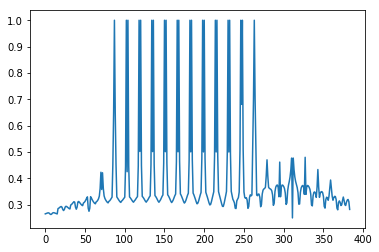

In [5]:
plt.plot(torch.exp(log_Pi).max(dim=1)[0].detach().numpy())

# IRL Navigation MDP

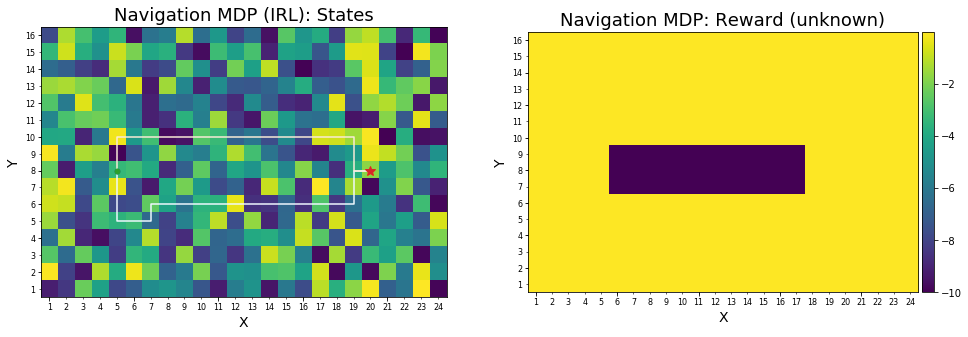

In [6]:
nvmdp_irl = NavigationWorldMDP(
    
    width = W, height = H,
    nav_cell_types = [*range(len(state_cells))],
    nav_cell_rewards = [*[-0.01]*len(state_cells)], # To create separate indicator feature for each obstacle cell.
    nav_cell_p_or_locs = [*[[o] for o in state_cells]],
    goal_cell_types = [],
    goal_cell_rewards = [],
    goal_cell_locs = [],
    slip_prob = 0.0, step_cost = 0,
    gamma = 0.95
)
# shuffle state ids for better cmap representation of our problem.
nvmdp_irl.map_state_cell_id = np.random.permutation(
    nvmdp_irl.map_state_cell_id.reshape(1,-1).squeeze()).reshape(nvmdp_irl.height, nvmdp_irl.width)

## MDP Params ------------------
# States
S = nvmdp_irl.get_all_states()
s_to_idx = {v:k for k,v in enumerate(S)}
# Rewards
R_s = nvmdp_irl._reward_func_state_only
R = torch.tensor([float(R_s(s)) for s in S], requires_grad=True)
R_grid = convert_to_grid(nvmdp_irl, S, R)
# Actions
A = nvmdp_irl.get_actions()
a_to_idx = {a:i for i,a in enumerate(A)}
# Dynamics
T = nvmdp_irl.transition_func
# Features
state_ids = [nvmdp_irl.map_state_cell_id[nvmdp_irl._xy_to_rowcol(*s)] for s in S]
# linear_phi = torch.FloatTensor([state_id_to_linear_feature(s_id) for s_id in state_ids])
# non_linear_phi = torch.FloatTensor([state_id_to_non_linear_feature(s_id) for s_id in state_ids])
one_hot_phi = torch.FloatTensor([nvmdp_irl.feature_at_state(s) for s in S])
phi = one_hot_phi
phi_fn = lambda s: phi[s_to_idx[s]]
def states_generator(trajectory):
    return S

def dynamics_generator_deterministic(trajectory):
    return lambda s,a: [(T(s,a), 1.)]

def dynamics_generator_border_walls(trajectory):
    return lambda s,a: [(T(s,a), 1.) if (s.x != 1 and s.y != 1 and s.x != nvmdp_irl.width and s.y != nvmdp_irl.height) else (None, 1.) ]


# -------------------------------

fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(121)
fig, ax = nvmdp_irl.visualize_grid(fig=fig, ax=ax, cmap=plt.cm.viridis, plot=False,
                                   trajectories=trajectories_states,
                                   init_marker=".", end_marker="*",
                                   title="Navigation MDP (IRL): States")
ax = fig.add_subplot(122)
_ = nvmdp_irl.visualize_grid(fig=fig, ax=ax, cmap=plt.cm.viridis, 
                             title="Navigation MDP: Reward (unknown)", values=convert_to_grid(nvmdp_irl, S, R_real), 
                             state_space_cmap=False, show_colorbar=True)

In [7]:
# dynamics_generator = dynamics_generator_border_walls
dynamics_generator = dynamics_generator_deterministic

In [96]:
phi_dim = len(phi_fn(S[0]))
temperature = 1.
gamma = 0.95
n_vi_iters = 120
vi_convergence_eps = 1e-4

n_maxent_iters = 10
n_mlirl_iters = n_maxent_iters
lr, weight_decay = 0.02, 0

## Test: effect of scale / norm of reward on convergence

In [11]:
import pandas as pd
scale = 1.
R = torch.randn(len(S)) * scale
boltzmann_policy = lambda Q, temp=1.: Planners.log_boltzmann_dist(Q, temp)
# torch.exp(boltzmann_policy(torch.tensor([100*-0.00, 100*-100.])))

# log_Pi, V, Q, s_to_idx, a_to_idx, iterno = Planners.value_iteration(
#                 S, A, R, dynamics_generator(0), boltzmann_policy, gamma, 10000, None, goal, convergence_eps=eps)

In [63]:
repeat = 5
results = []
convergence_eps_list = np.linspace(0.001, 0.1, 10) #[0.00001, 0.0001, 0.001, 0.01, 0.1]
for eps in convergence_eps_list:
    iters = []
    for scale in np.linspace(0.001, 1.0, 10): #[0.001, 0.01, 0.1, 1.0, 10., 100.]:
        for _ in range(repeat):
            R = torch.randn(len(S)) * scale
            log_Pi, V, Q, s_to_idx, a_to_idx, iterno = Planners.value_iteration(
                S, A, R, dynamics_generator(0), boltzmann_policy, gamma, 10000, None, goal, convergence_eps=eps)
            print("Eps: ", eps, "Scale: ", scale, "-> iters: ", iterno)
            results.append((eps, scale, iterno))

Eps:  0.001 Scale:  0.001 -> iters:  3
Eps:  0.001 Scale:  0.001 -> iters:  2
Eps:  0.001 Scale:  0.001 -> iters:  3
Eps:  0.001 Scale:  0.001 -> iters:  4
Eps:  0.001 Scale:  0.001 -> iters:  3
Eps:  0.001 Scale:  0.112 -> iters:  56
Eps:  0.001 Scale:  0.112 -> iters:  61
Eps:  0.001 Scale:  0.112 -> iters:  48
Eps:  0.001 Scale:  0.112 -> iters:  67
Eps:  0.001 Scale:  0.112 -> iters:  47
Eps:  0.001 Scale:  0.223 -> iters:  82
Eps:  0.001 Scale:  0.223 -> iters:  89
Eps:  0.001 Scale:  0.223 -> iters:  74
Eps:  0.001 Scale:  0.223 -> iters:  94
Eps:  0.001 Scale:  0.223 -> iters:  97
Eps:  0.001 Scale:  0.334 -> iters:  75
Eps:  0.001 Scale:  0.334 -> iters:  77
Eps:  0.001 Scale:  0.334 -> iters:  90
Eps:  0.001 Scale:  0.334 -> iters:  83
Eps:  0.001 Scale:  0.334 -> iters:  74
Eps:  0.001 Scale:  0.445 -> iters:  95
Eps:  0.001 Scale:  0.445 -> iters:  89
Eps:  0.001 Scale:  0.445 -> iters:  90
Eps:  0.001 Scale:  0.445 -> iters:  107
Eps:  0.001 Scale:  0.445 -> iters:  98
Eps:

Eps:  0.034 Scale:  0.778 -> iters:  64
Eps:  0.034 Scale:  0.778 -> iters:  81
Eps:  0.034 Scale:  0.778 -> iters:  76
Eps:  0.034 Scale:  0.889 -> iters:  62
Eps:  0.034 Scale:  0.889 -> iters:  67
Eps:  0.034 Scale:  0.889 -> iters:  58
Eps:  0.034 Scale:  0.889 -> iters:  59
Eps:  0.034 Scale:  0.889 -> iters:  77
Eps:  0.034 Scale:  1.0 -> iters:  68
Eps:  0.034 Scale:  1.0 -> iters:  75
Eps:  0.034 Scale:  1.0 -> iters:  102
Eps:  0.034 Scale:  1.0 -> iters:  64
Eps:  0.034 Scale:  1.0 -> iters:  82
Eps:  0.045000000000000005 Scale:  0.001 -> iters:  1
Eps:  0.045000000000000005 Scale:  0.001 -> iters:  1
Eps:  0.045000000000000005 Scale:  0.001 -> iters:  1
Eps:  0.045000000000000005 Scale:  0.001 -> iters:  1
Eps:  0.045000000000000005 Scale:  0.001 -> iters:  1
Eps:  0.045000000000000005 Scale:  0.112 -> iters:  11
Eps:  0.045000000000000005 Scale:  0.112 -> iters:  10
Eps:  0.045000000000000005 Scale:  0.112 -> iters:  10
Eps:  0.045000000000000005 Scale:  0.112 -> iters:  11

Eps:  0.07800000000000001 Scale:  0.112 -> iters:  5
Eps:  0.07800000000000001 Scale:  0.112 -> iters:  10
Eps:  0.07800000000000001 Scale:  0.112 -> iters:  5
Eps:  0.07800000000000001 Scale:  0.112 -> iters:  7
Eps:  0.07800000000000001 Scale:  0.223 -> iters:  31
Eps:  0.07800000000000001 Scale:  0.223 -> iters:  15
Eps:  0.07800000000000001 Scale:  0.223 -> iters:  15
Eps:  0.07800000000000001 Scale:  0.223 -> iters:  24
Eps:  0.07800000000000001 Scale:  0.223 -> iters:  16
Eps:  0.07800000000000001 Scale:  0.334 -> iters:  29
Eps:  0.07800000000000001 Scale:  0.334 -> iters:  26
Eps:  0.07800000000000001 Scale:  0.334 -> iters:  27
Eps:  0.07800000000000001 Scale:  0.334 -> iters:  28
Eps:  0.07800000000000001 Scale:  0.334 -> iters:  24
Eps:  0.07800000000000001 Scale:  0.445 -> iters:  37
Eps:  0.07800000000000001 Scale:  0.445 -> iters:  35
Eps:  0.07800000000000001 Scale:  0.445 -> iters:  35
Eps:  0.07800000000000001 Scale:  0.445 -> iters:  33
Eps:  0.07800000000000001 Scale

In [90]:
df = pd.DataFrame(results, columns=["eps", "scale", "iters"])
# df.to_csv("./IRL_NavigationGrid_results/EXP_IRL_NavigationGrid3__VI_convergence_results.csv")
df = df.groupby(["eps", "scale"])
df = df.agg(np.mean)
df.head()
df.reset_index(inplace=True)
# df.to_csv("./IRL_NavigationGrid_results/EXP_IRL_NavigationGrid3__VI_convergence_results__processed.csv")

Text(0,0.5,'Iterations')

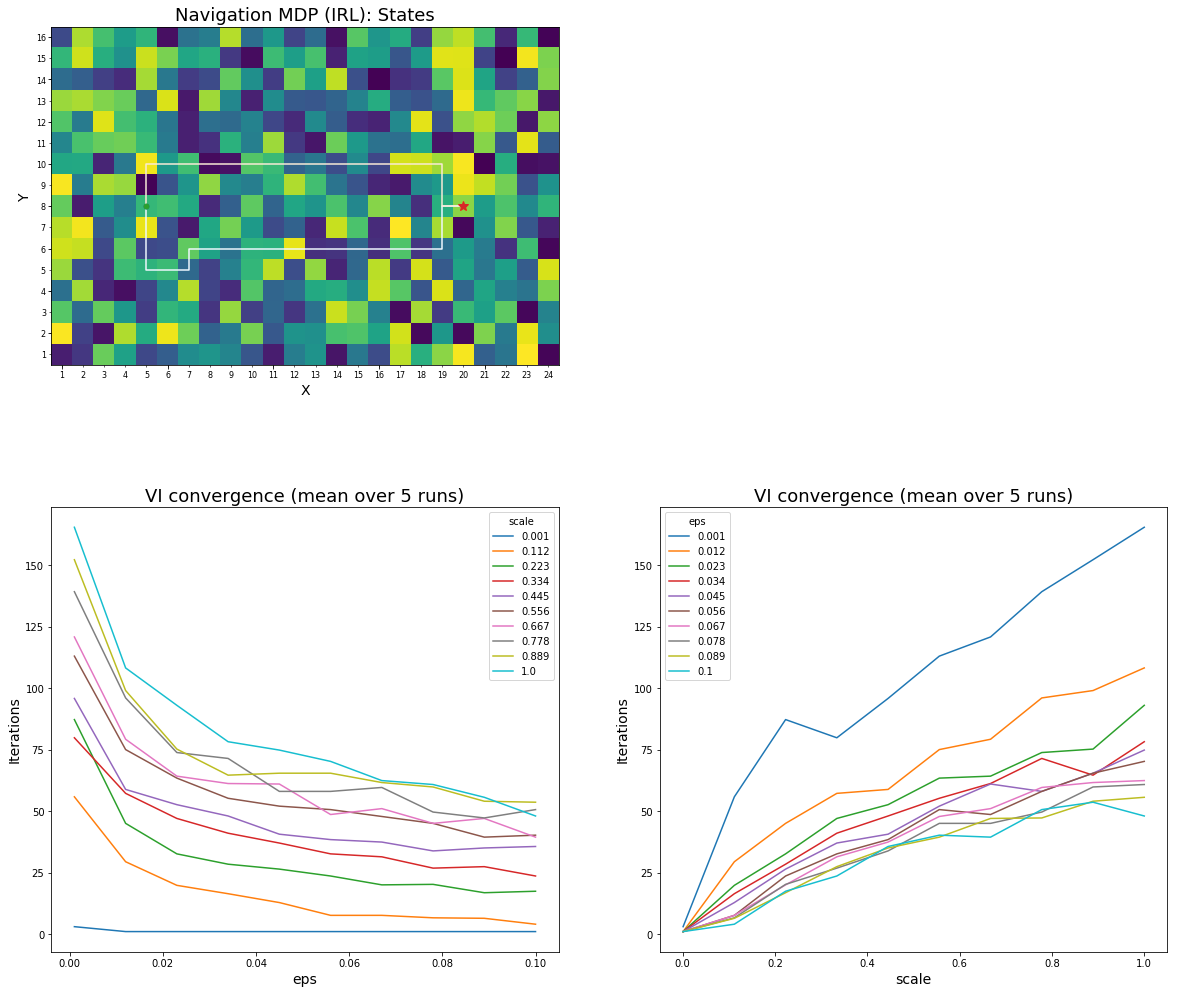

In [95]:
fig = plt.figure(figsize=(20,18))

ax = fig.add_subplot(221)
fig, ax = nvmdp_irl.visualize_grid(fig=fig, ax=ax, cmap=plt.cm.viridis, plot=False,
                                   trajectories=trajectories_states,
                                   init_marker=".", end_marker="*",
                                   title="Navigation MDP (IRL): States")
ax = fig.add_subplot(223)
df.round(3).pivot(index="eps", columns="scale", values="iters").plot(ax=ax, title="VI convergence (mean over 5 runs)")
plt.ylabel("Iterations")
ax = fig.add_subplot(224)
df.round(3).pivot(index="scale", columns="eps", values="iters").plot(ax=ax, title="VI convergence (mean over 5 runs)")
plt.ylabel("Iterations")

# MaxEnt IRL

In [118]:
phi_dim = len(phi_fn(S[0]))
temperature = 1.
gamma = 0.95
n_vi_iters = 150
vi_convergence_eps = 1e-4

n_maxent_iters = 10
n_mlirl_iters = n_maxent_iters
lr, weight_decay = 0.1, 0

In [134]:
R_model = Models.LinearRewardModel_Tanh(phi_dim, -0.1, steep=10000000.)
np.asarray([R_model(torch.FloatTensor(x)).item() for x in np.random.uniform(-10,10,(100,phi_dim))])

array([-1.10000002, -1.10000002,  0.89999998, -1.10000002,  0.89999998,
        0.89999998, -1.10000002, -1.10000002,  0.89999998, -1.10000002,
       -1.10000002, -1.10000002, -1.10000002,  0.89999998, -1.10000002,
        0.89999998, -1.10000002, -1.10000002, -1.10000002,  0.89999998,
       -1.10000002,  0.89999998,  0.89999998,  0.89999998, -1.10000002,
        0.89999998,  0.89999998, -1.10000002,  0.89999998, -1.10000002,
        0.89999998,  0.89999998,  0.89999998,  0.89999998,  0.89999998,
       -1.10000002,  0.89999998, -1.10000002, -1.10000002, -1.10000002,
        0.89999998,  0.89999998, -1.10000002,  0.89999998,  0.89999998,
        0.89999998,  0.89999998,  0.89999998, -1.10000002, -1.10000002,
        0.89999998,  0.89999998,  0.89999998,  0.89999998, -1.10000002,
        0.89999998, -1.10000002,  0.89999998,  0.89999998,  0.89999998,
        0.89999998,  0.89999998,  0.89999998, -1.10000002, -1.10000002,
       -1.10000002,  0.89999998,  0.89999998, -1.10000002, -1.10

In [139]:
np.random.seed(1)
torch.manual_seed(1)
# R model
# R_model = Models.LinearRewardModel_ReLU(phi_dim, 0)
R_model = Models.LinearRewardModel_Tanh(phi_dim, -1.01, steep=1.)
R_model.apply(lambda x: weights_init(x, mu=-1, std=0)) # std = 0 => constant reward function with all mass at mu.

with torch.no_grad():
    R_grid_init = convert_to_grid(nvmdp_irl, S, torch.tensor([R_model(phi_fn(s)) for s in S], requires_grad=False))

# Test: non-positive R
assert np.alltrue(np.asarray([R_model(torch.FloatTensor(x)).item() for x in np.random.uniform(-10,10,(100,phi_dim))]) <= 0)
# Optimizer
optimizer_fn=lambda params, lr, weight_decay: optim.Adam(params, lr=lr, weight_decay=weight_decay)
R_optimizer = optimizer_fn(R_model.parameters(), lr, weight_decay)

maxent_loss_history, maxent_learned_policies, maxent_log_likelihoods, maxent_vi_iters = MaxEntIRL(
    trajectories, states_generator, dynamics_generator, A, phi_fn, 
    R_model, R_optimizer, gamma, n_maxent_iters, n_vi_iters, boltzmann_temp=temperature,
    verbose=True, debug=False, insane_debug=False, vi_convergence_eps=vi_convergence_eps)

maxent_R_grid = convert_to_grid(nvmdp_irl, S, torch.tensor([R_model(phi_fn(s)) for s in S], requires_grad=False))

MaxEntIRL params 
-----
	 Domains: 2, sizes: [384, 384],
	 Action dim: 4, 
	 Feature dim: 384,
	 Iterations: 10, 
	 Max likelihood: 0.99,
	 VI iterations: 150, 
	 VI convergence eps: 0.0001,
	 Gamma (discount factor): 0.95,
Running Backward Pass  [ ... ] Backward pass converged @ 110.
Running Backward Pass  [ ... ] Backward pass converged @ 110.

>>> Iter: 0000 (5.305s): loss = 00.004029, likelihood = 0.0000


Running Backward Pass  [ ... ] Backward pass converged @ 107.
Running Backward Pass  [ ... ] Backward pass converged @ 107.

>>> Iter: 0001 (5.013s): loss = 00.003854, likelihood = 0.0000


Running Backward Pass  [ ... ] Backward pass converged @ 103.
Running Backward Pass  [ ... ] Backward pass converged @ 103.

>>> Iter: 0002 (4.843s): loss = 00.003647, likelihood = 0.0000


Running Backward Pass  [ ... ] Backward pass converged @ 100.
Running Backward Pass  [ ... ] Backward pass converged @ 100.

>>> Iter: 0003 (4.665s): loss = 00.003436, likelihood = 0.0000


Running Backward

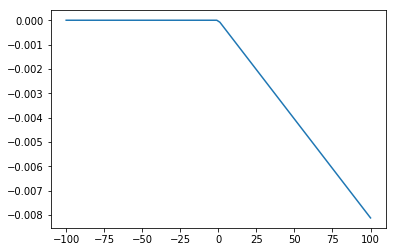

In [93]:
steep = 0.01
bias = 0
mag = 1.

relu_model = Models.LinearRewardModel_ReLU(1, bias, mag, steep, invert=True)
relu_model.apply(lambda x: weights_init(x, mu=-1, std=1e-100))
x = torch.linspace(-100.,100.,100).reshape(-1,1)
y_relu = relu_model(x).detach().numpy()
plt.plot(x.numpy(), y)
# plt.xlim([-100,100])
# plt.ylim([-300, 0])

In [166]:
# ---------------
# 3D surface plot 
# ---------------
def get_xyz(img_2d):
    
    x_list, y_list, z_list = [], [], []
    for row in range(len(img_2d)):
        for col in range(len(img_2d[0])):
            x, y = row, col
            x_list.append(x)
            y_list.append(y)
            z_list.append(img_2d[row, col])
    return x_list, y_list, z_list

def plot_3d_surface(img_2d, fig, zlim=(-3,-1), view=(25, -110), cmap=plt.cm.jet):
    """
    Ref: https://python-graph-gallery.com/371-surface-plot/
    """
    X, Y, Z = get_xyz(img_2d)
    # ax = fig.add_subplot(122)
    ax = fig.gca(projection='3d')
    ax.plot_trisurf(Y, X, Z, cmap=plt.cm.jet, linewidth=0.2)
    ax.set_zlim(*zlim)
    
    ax.invert_yaxis()
    ax.view_init(*view)
    
    # to Add a color bar which maps values to colors.
    surf=ax.plot_trisurf(Y, X, Z, cmap=plt.cm.jet, linewidth=0.2)
    fig.colorbar(surf, shrink=0.5, aspect=5)

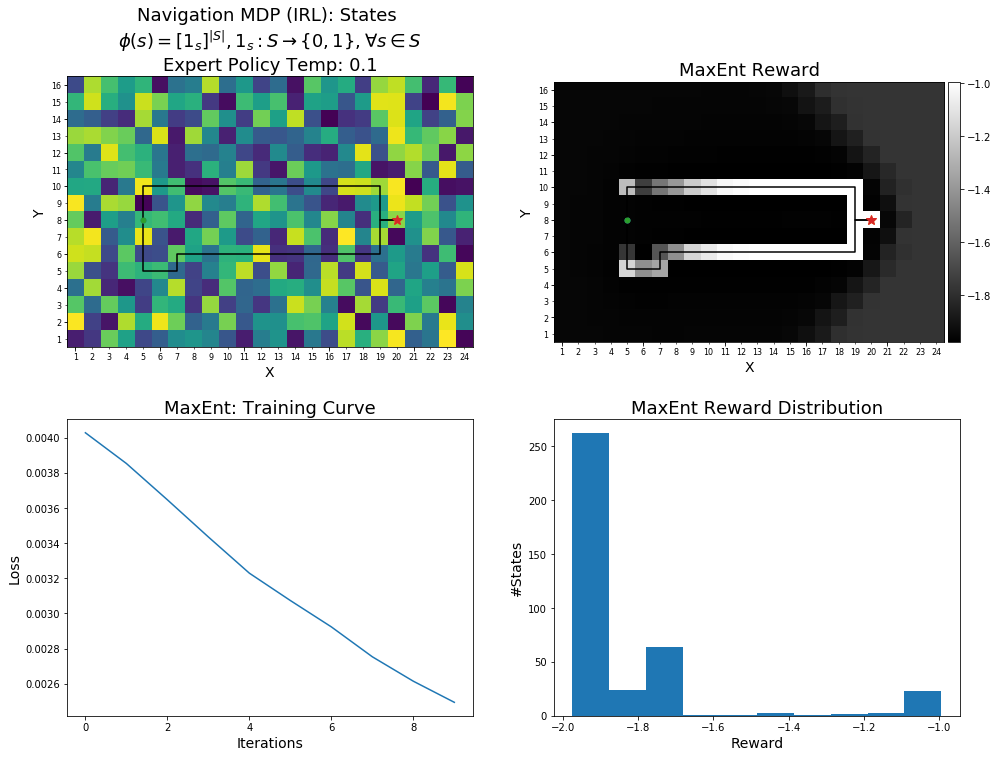

In [167]:
maxent_R_grid = convert_to_grid(nvmdp_irl, S, torch.tensor([R_model(phi_fn(s)) for s in S], requires_grad=False))

fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(221)
fig, ax = nvmdp_irl.visualize_grid(fig=fig, ax=ax, cmap=plt.cm.viridis, plot=False, 
                                   trajectories=trajectories_states,
                                   init_marker=".", end_marker="*", 
                                   traj_marker="-k", traj_colors_auto=False,
                                   title=\
        "Navigation MDP (IRL): States \n" +\
        r"$ \phi(s) = [1_s]^{|S|}, 1_s: S \rightarrow \{0,1\},\forall s \in S$" +\
        "\nExpert Policy Temp: {}".format(EXPERT_TEMP))

ax = fig.add_subplot(222)
_ = nvmdp_irl.visualize_grid(fig=fig, ax=ax, cmap=plt.cm.gray, show_colorbar=True, plot=False,
                             trajectories=trajectories_states,
                             init_marker=".", end_marker="*", 
                             traj_marker="-k", traj_colors_auto=False,
                             title="MaxEnt Reward", values=maxent_R_grid,
                             state_space_cmap=False)
ax = fig.add_subplot(223)
plt.plot(maxent_loss_history)
plt.ylabel("Loss")
plt.xlabel("Iterations")
plt.title("MaxEnt: Training Curve")

ax = fig.add_subplot(224)
plt.hist(maxent_R_grid.reshape(1,-1).squeeze())
plt.ylabel("#States")
plt.xlabel("Reward")
plt.title("MaxEnt Reward Distribution")
plt.show()

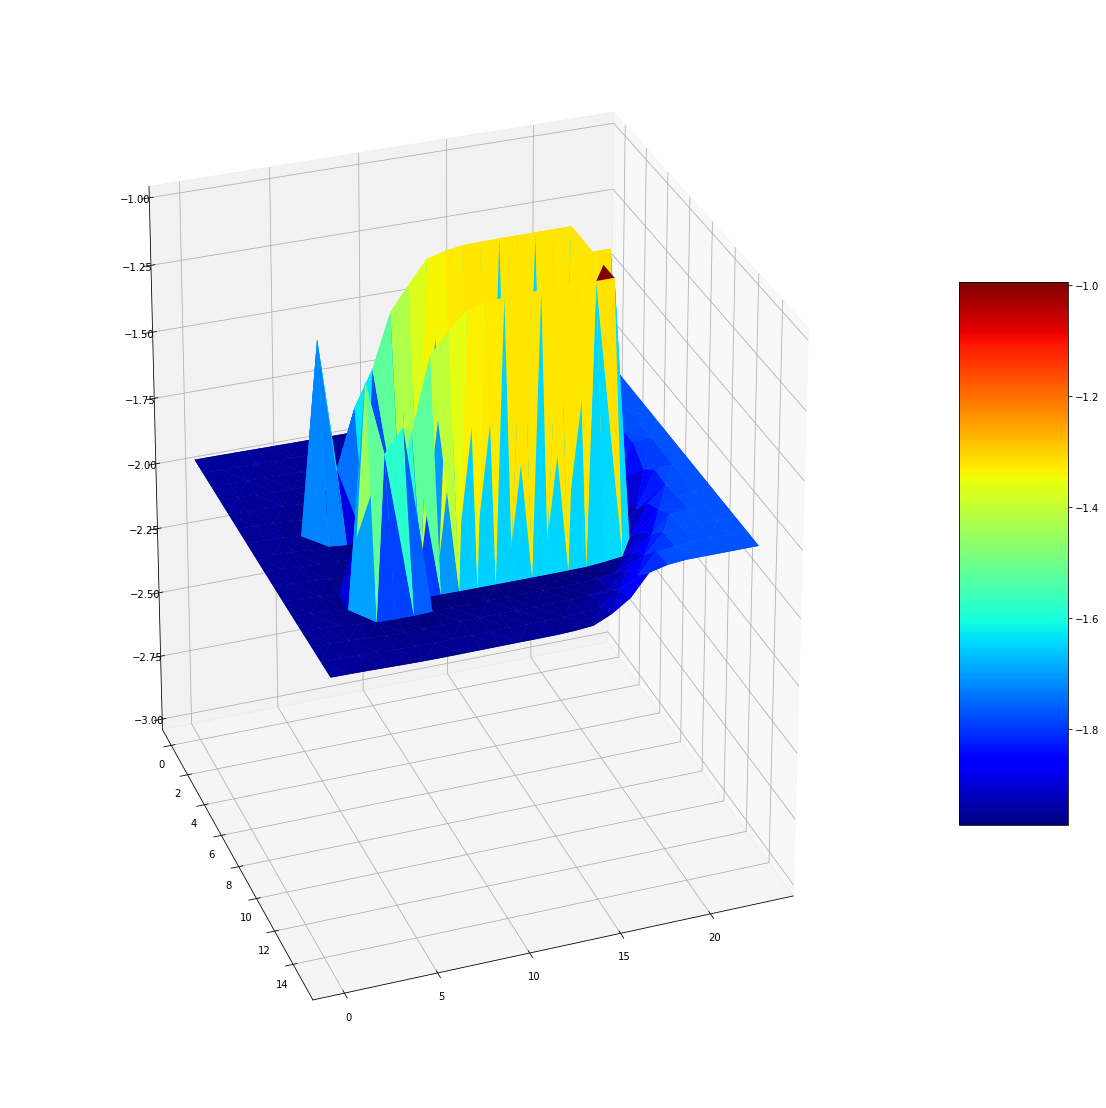

In [169]:
fig = plt.figure(figsize=(20,20))
plot_3d_surface(maxent_R_grid, fig)
plt.show()

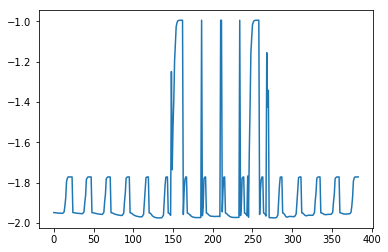

In [170]:
plt.plot(maxent_R_grid.reshape(-1,1).squeeze())

(array([262.,  24.,  64.,   1.,   1.,   3.,   1.,   2.,   3.,  23.]),
 array([-1.97485185, -1.87678043, -1.77870902, -1.6806376 , -1.58256619,
        -1.48449478, -1.38642336, -1.28835195, -1.19028053, -1.09220912,
        -0.9941377 ]),
 <a list of 10 Patch objects>)

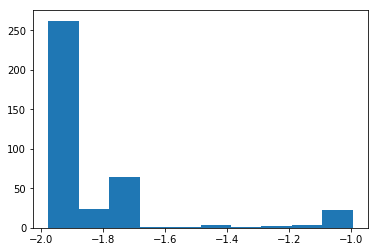

In [171]:
plt.hist(maxent_R_grid.reshape(-1,1).squeeze())

# MLIRL

In [ ]:
np.random.seed(1)
torch.manual_seed(1)
# R model
# R_model = Models.LinearRewardModel_Tanh(phi_dim, -1.01, steep=10.)
R_model = Models.LinearRewardModel_ReLU(phi_dim, out_bias=-0.01, gain=1., steep=0.01, invert=True)
R_model.apply(lambda x: weights_init(x, mu=-1.0, std=0))
# for p in R_model.parameters():
#     print(p)
# Test: non-positive R
# assert np.alltrue(np.asarray([R_model(torch.FloatTensor(x)).item() for x in np.random.uniform(-10,10,(100,phi_dim))]) <= 0)
# Optimizer
optimizer_fn=lambda params, lr, weight_decay: optim.Adam(params, lr=lr, weight_decay=weight_decay)
R_optimizer = optimizer_fn(R_model.parameters(), lr, weight_decay)

policy = lambda Q, temp=temperature: Planners.log_boltzmann_dist(Q, temp)

mlirl_loss_history, mlirl_learned_policies, mlirl_log_likelihoods_history, mlirl_vi_iters = MLIRL(
                trajectories, states_generator, dynamics_generator, A, phi_fn, R_model, R_optimizer, 
                policy, gamma, n_mlirl_iters, n_vi_iters, verbose=True, 
    vi_convergence_eps=vi_convergence_eps)

MLIRL params 
-----
	 Domains: 2, sizes: [384, 384],
	 Action dim: 4, 
	 Feature dim: 384,
	 Iterations: 10, 
	 Max likelihood: 0.99,
	 VI iterations: 150, 
	 VI convergence eps: 0.0001,
	 Gamma (discount factor): 0.95, 
	 Policy example: Q tensor([0.0000, 0.3333, 0.6667, 1.0000]) -> Pi tensor([-1.9547, -1.6213, -1.2880, -0.9547])
R max:  -1.7715941667556763  R min:  -1.7715941667556763
Running VI [ . ] VI converged @ 41.
V max:  0.0  V min:  -30.69556427001953
R max:  -1.7715941667556763  R min:  -1.7715941667556763
Running VI [ . ] VI converged @ 41.
V max:  0.0  V min:  -30.69556427001953

>>> Iter: 0000 (25.878s): loss = 31.792400, likelihood = 0.0000


R max:  -1.7262978553771973  R min:  -1.8104989528656006
Running VI [ . ] VI converged @ 40.
V max:  0.0  V min:  -30.666099548339844
R max:  -1.7262978553771973  R min:  -1.8104989528656006
Running VI [ . ] VI converged @ 40.
V max:  0.0  V min:  -30.666099548339844

>>> Iter: 0001 (24.357s): loss = 28.943151, likelihood = 0.0000



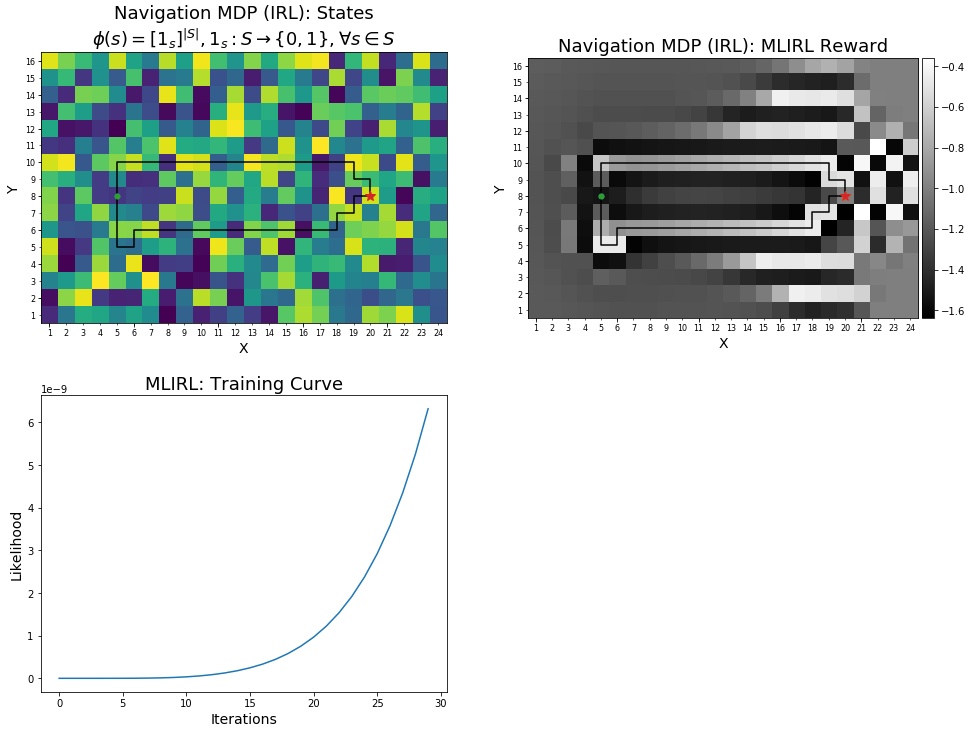

In [140]:
mlirl_R_grid = convert_to_grid(nvmdp_irl, S, torch.tensor([R_model(phi_fn(s)) for s in S], requires_grad=False))

fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(221)
fig, ax = nvmdp_irl.visualize_grid(fig=fig, ax=ax, cmap=plt.cm.viridis, plot=False, 
                                   trajectories=trajectories_states,
                                   init_marker=".", end_marker="*", 
                                   traj_marker="-k", traj_colors_auto=False,
                                   title="Navigation MDP (IRL): States\n" + r"$ \phi(s) = [1_s]^{|S|}, 1_s: S \rightarrow \{0,1\},\forall s \in S$")
ax = fig.add_subplot(222)
_ = nvmdp_irl.visualize_grid(fig=fig, ax=ax, cmap=plt.cm.gray, show_colorbar=True, plot=False,
                             trajectories=trajectories_states,
                             init_marker=".", end_marker="*", 
                             traj_marker="-k", traj_colors_auto=False,
                             title="Navigation MDP (IRL): MLIRL Reward", values=mlirl_R_grid,
                             state_space_cmap=False)
ax = fig.add_subplot(223)
plt.plot(np.exp(-np.asarray(mlirl_loss_history)))
plt.ylabel("Likelihood")
plt.xlabel("Iterations")
plt.title("MLIRL: Training Curve")
plt.show()

In [142]:
import seaborn as sns

Text(0.5,0.98,'11x11 Navigation grid experiment. (Learning rate: 0.02, weight decay: 0\n Gamma: 0.950, #backups: 400, mlirl iters: 30, maxent iters: 30\n VI convergence eps: 0.0001)')

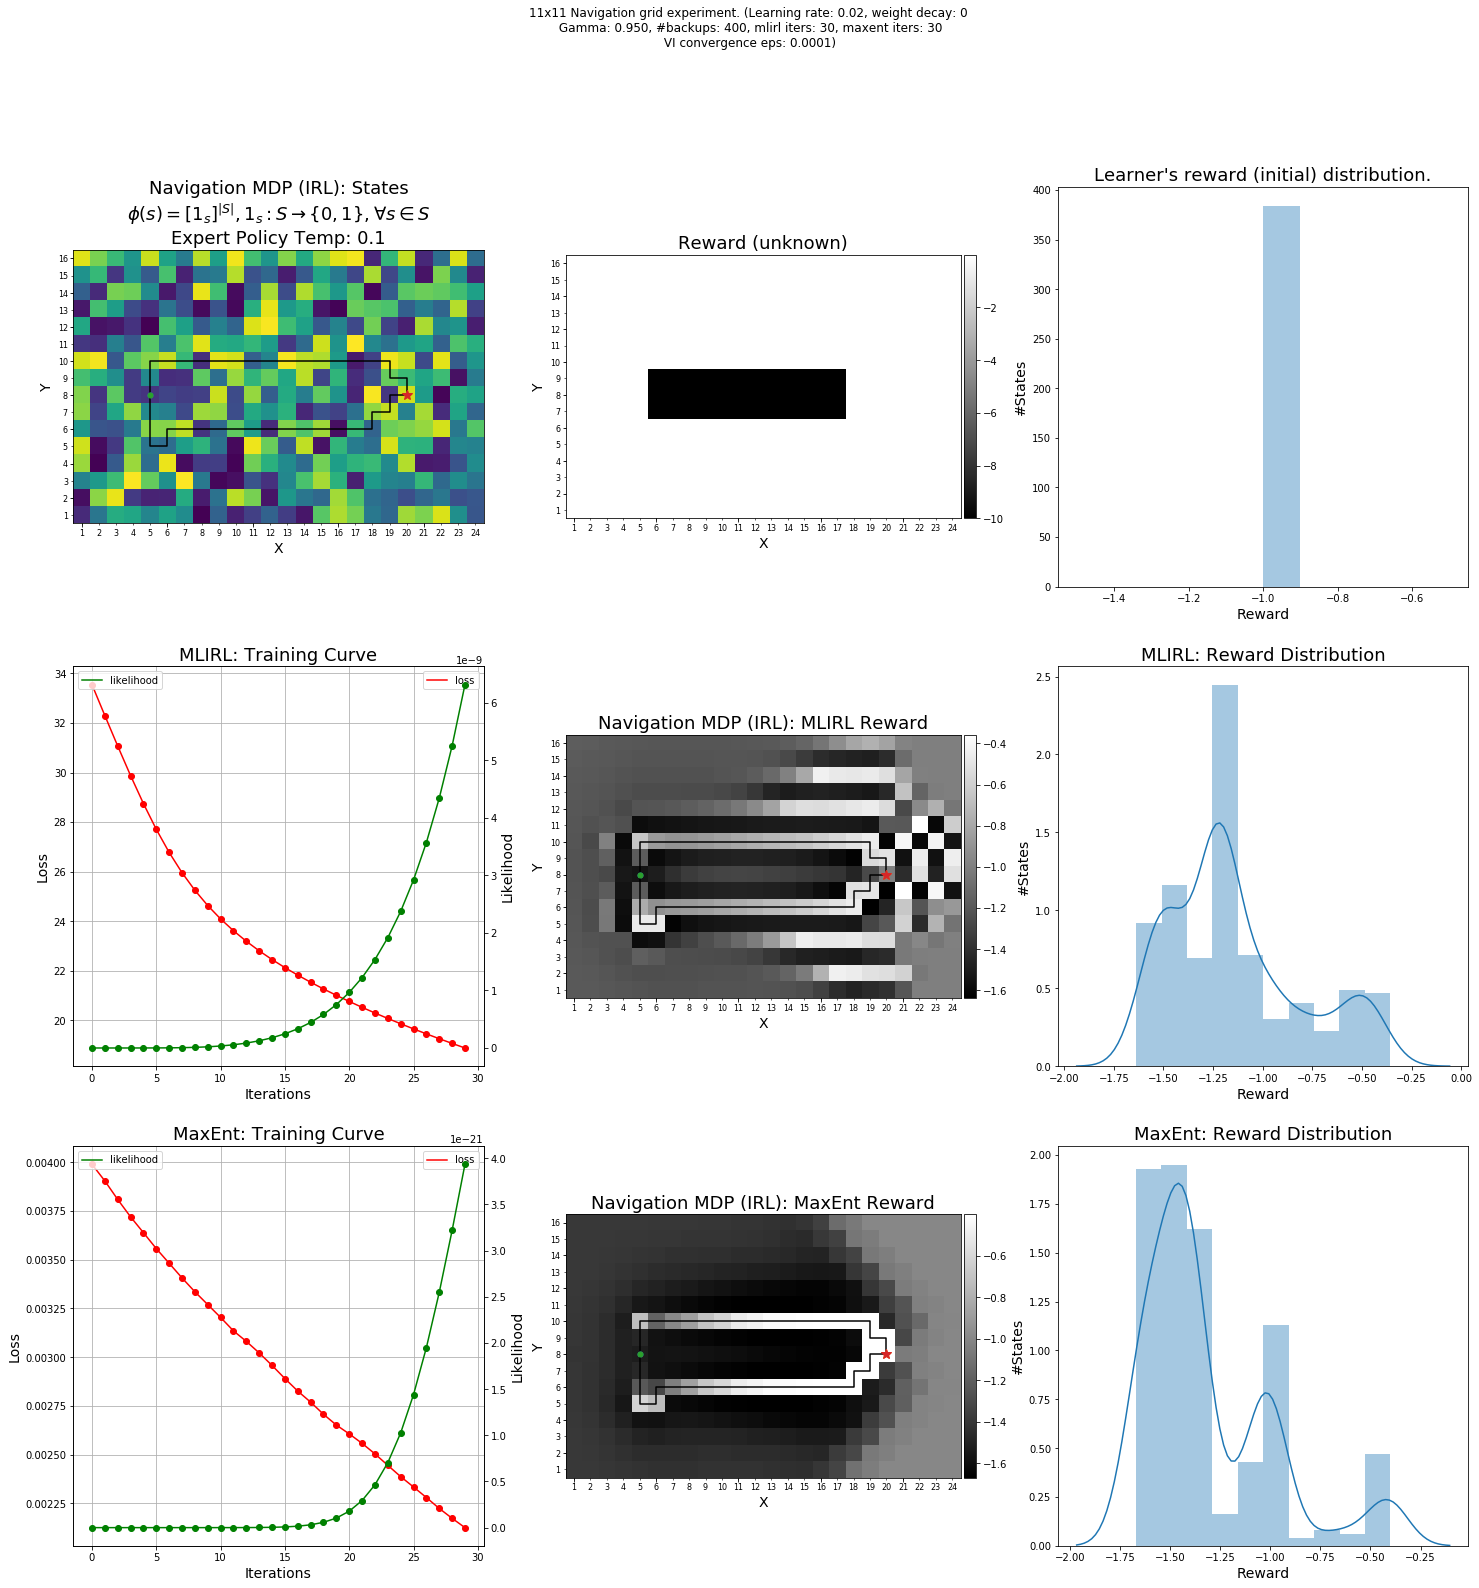

In [143]:
fig = plt.figure(figsize=(25,25))
ax = fig.add_subplot(331)
fig, ax = nvmdp_irl.visualize_grid(fig=fig, ax=ax, cmap=plt.cm.viridis, plot=False, 
                                   trajectories=trajectories_states,
                                   init_marker=".", end_marker="*", 
                                   traj_marker="-k", traj_colors_auto=False,
                                   title=\
        "Navigation MDP (IRL): States\n" +\
        r"$ \phi(s) = [1_s]^{|S|}, 1_s: S \rightarrow \{0,1\},\forall s \in S$" +\
        "\nExpert Policy Temp: {}".format(EXPERT_TEMP))

ax = fig.add_subplot(332)
fig, ax = nvmdp_irl.visualize_grid(fig=fig, ax=ax, cmap=plt.cm.gray, plot=False, 
                             title="Reward (unknown)", values=convert_to_grid(nvmdp_irl, S, R_real), 
                             state_space_cmap=False, show_colorbar=True)
ax = fig.add_subplot(333)
sns.distplot(R_grid_init.reshape(1,-1).squeeze(), hist=True, kde=False, bins=10)
# plt.hist(R_grid_init.reshape(1,-1).squeeze(), 100, density=1)
plt.ylabel("#States")
plt.xlabel("Reward")
plt.title("Learner's reward (initial) distribution.")


ax = fig.add_subplot(334)
plt.plot(mlirl_loss_history, "r", label="loss")
plt.plot(mlirl_loss_history, "ro")
plt.grid(True)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.axis('tight')
plt.legend()
ax_2 = ax.twinx()
plt.plot(np.exp(-np.asarray(mlirl_loss_history)), "g",label="likelihood")
plt.plot(np.exp(-np.asarray(mlirl_loss_history)), "go")
plt.xlabel("Iterations")
plt.ylabel("Likelihood")
plt.legend()
plt.axis('tight')
plt.title("MLIRL: Training Curve")


ax = fig.add_subplot(335)
_ = nvmdp_irl.visualize_grid(fig=fig, ax=ax, cmap=plt.cm.gray, show_colorbar=True, plot=False,
                             trajectories=trajectories_states,
                             init_marker=".", end_marker="*", 
                             traj_marker="-k", traj_colors_auto=False,
                             title="Navigation MDP (IRL): MLIRL Reward", values=mlirl_R_grid,
                             state_space_cmap=False)

ax = fig.add_subplot(336)
sns.distplot(mlirl_R_grid.reshape(1,-1).squeeze(), hist=True, kde=True, bins=10)
# plt.hist(mlirl_R_grid.reshape(1,-1).squeeze(), 100, density=1)
plt.ylabel("#States")
plt.xlabel("Reward")
plt.title("MLIRL: Reward Distribution")

ax = fig.add_subplot(337)
plt.plot(maxent_loss_history, "r", label="loss")
plt.plot(maxent_loss_history, "ro")
plt.grid(True)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.axis('tight')
plt.legend()
ax_2 = ax.twinx()
plt.plot(np.exp(np.asarray(maxent_log_likelihoods)), "g",label="likelihood")
plt.plot(np.exp(np.asarray(maxent_log_likelihoods)), "go")
plt.xlabel("Iterations")
plt.ylabel("Likelihood")
plt.legend()
plt.axis('tight')
plt.title("MaxEnt: Training Curve")

ax = fig.add_subplot(338)
_ = nvmdp_irl.visualize_grid(fig=fig, ax=ax, cmap=plt.cm.gray, show_colorbar=True, plot=False,
                             trajectories=trajectories_states,
                             init_marker=".", end_marker="*", 
                             traj_marker="-k", traj_colors_auto=False,
                             title="Navigation MDP (IRL): MaxEnt Reward", values=maxent_R_grid,
                             state_space_cmap=False)

ax = fig.add_subplot(339)
sns.distplot(maxent_R_grid.reshape(1,-1).squeeze(), hist=True, kde=True, bins=10)
# plt.hist(maxent_R_grid.reshape(1,-1).squeeze(), 100, density=1)
plt.ylabel("#States")
plt.xlabel("Reward")
plt.title("MaxEnt: Reward Distribution")

plt.suptitle("11x11 Navigation grid experiment."
             " (Learning rate: {}, weight decay: {}"
             "\n Gamma: {:2.3f}, #backups: {},"
             " mlirl iters: {}, maxent iters: {}"
             "\n VI convergence eps: {})".format(lr, weight_decay, gamma, n_vi_iters, n_mlirl_iters, n_maxent_iters, vi_convergence_eps))

# fig.tight_layout()

### Experiment: test MLIRL and MaxEnt on toy navigation world.

**Details:**
The MDP is 11x11 grid-world, which is shown in top left graph. Each state of this MDP has an associated indicator feature, cardinality of feature space is same as state space. (I couldn’t find a better LaTeX notation to represent unique one-hot encoding). There are two trajectories, each going around some part of the state space (this were sampled using another MDP with actual obstacle in the middle and finding path using A* search with given goal and start states). The reward is not given in IRL, both algorithms start with initial reward distribution which is gaussian centered at -1 with std de of 0.01.

**Plots:**
The plot on top right shows initial reward distribution used by MaxEnt and MLIRL.

The 4 plots in the bottom show MaxEnt and MLIRL results. The left column shows training performance and the right one recovered reward.

**Observations:**
It’s interesting that likelihood increases with very similar rate, however, the scale of likelihood is quite low, much lower in the case of MaxEnt. In 20 iterations, MLIRL achieves likelihood of ~0.0012 compared to 2.5 * 10^-15 in case of MaxEnt.

The rewards look quite similar, except white streak in the bottom and 5 bright corners in MLIRL recovered reward. I don’t know how increase reward on those states help algorithm maximize expert data likelihood.

I don’t understand why likelihood doesn’t increases much. I suspect it’s related to higher dimensionality of the state space.

**Thoughts:**
Maybe the slow convergence is because the trade off is challenging in higher dimensional space. The difference is like solving 2 equation vs. 100 equations.
Just to compare, Matrix inversion, method to solve a system of equations, takes O(n^3) time (O(n^2.807) using Strassen’s algorithm).

Yagnesh Revar [10:15 AM]
Ran the same experiment for 200 iterations. It took quite a while, especially MLIRL.

MaxEnt took roughly 1.5 sec per iteration, whereas MLIRL time varied from 4 sec to 75 seconds!

MaxEnt backward pass converged ALWAYS in approximately 102/103 backups (102 for trajectory bottom, 203 for top one). MLIRL value iteration was hit and miss. It started converging in 24/25 backups, grew to 58/71 by iteration 10, 202/242 by iteration 30, and so on. I had max #backup set to 400, later in the training VI convergence was hit and miss, and in the end it ALWAYS didn’t converge in 400 backups.

(Note on terminology: “iterations” is used to describe outer loop of IRL algorithm, and “backups” is used to describe VI iterations /backups).

This suggests that convergence is a problem in my MLIRL implementation. Need to somehow limit the magnitude of values. Should we clip gradients I wonder.

Yagnesh Revar [10:29 AM]
It makes sense. In the beginning of training we have no idea about the cost. So even after VI convergence, the paths we get aren’t optimal so we don’t get good credit assignment. The positive gradient won’t propagate to just a path taken by expert but many paths leading to goal from each point in the expert trajectory depending on the assumed cost distribution.

The basis of learning good costs is reasonable selection of paths, and the basis of selection of path is understanding of cost. It’s chicken and egg problem. The more states we have, the harder it becomes.
Ah, we know something about the cost that can be used in reasoning. The initial distribution shouldn’t be random! We know something that we can use, the law of energy conservation and that experts have finite energy. WOOT!

**Idea**
What id we add step cost in Q computation, that way values will select the optimal paths from the beginning. Then we can make them not optimal based on gradients of expert data likelihood.   
**Result**  
~~It did not help in faster convergence (Uh oh, same old R was used! need to revisit). I'm thinking learning rate is too high, let's lower down and see.~~ Nope, it didn't help at all. **Same effect can also be achieved with constant negative reward in the initialization.**

**Lower Learning rate**  
**Result:**  
**That was very helpful.**
Not to believe too much in something from the beginning (assumptions). Maybe it's also good to increase the learning rate as we move further in the training.  
**DC Level reward also plays imp role, and so the step cost.**
The more it is, the longer it'll take to bring it down for good states. VI convergence slows down with increase in -ve mean value of reward and step cost.

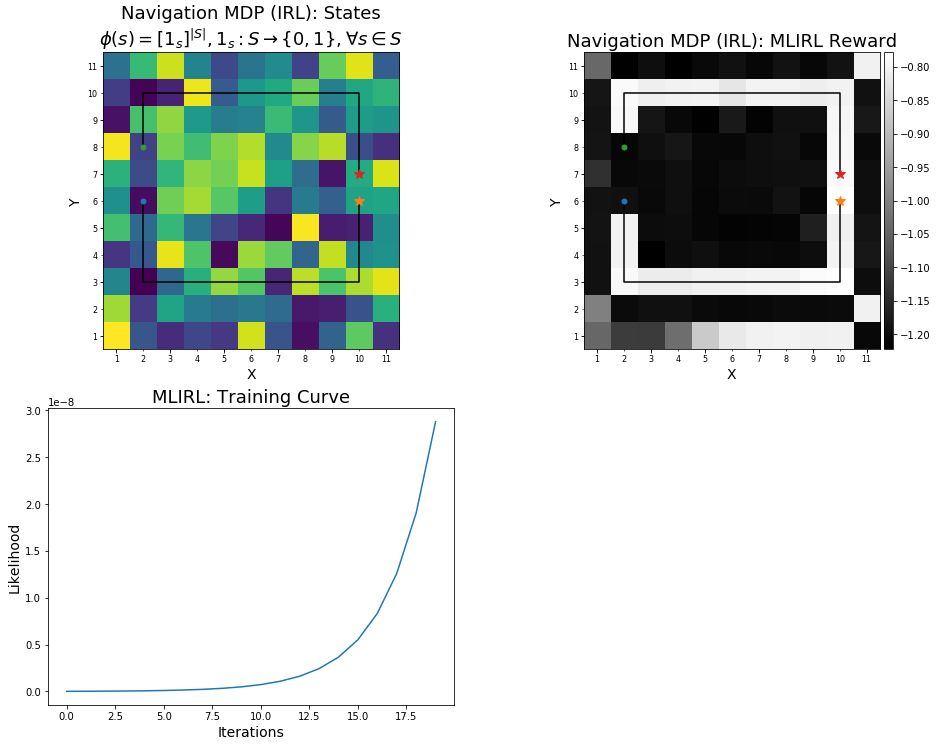

I thought about adding A* costs, but then realized the same effect could also be achieved by step cost. I added step cost, and instead of sampling reward from narrow normal distribution centered at -1, I used constant R of -1 so that initial gradients flow on the least cost paths and make them more negative if expert didn’t take them.

However, I learned later that the same effect could also be achieved by if we use step cost of 0 (i.e., don’t use it) with constant negative reward.

What helped the most was lowering the learning rate. I think it’s especially useful in the beginning phase. When we don’t know much about the world, why bet more. What if it turns out to be wrong, we’ll have to come down where we were and start over. This happens over all states. VI convergence slows down because somewhere we assume lots of value based on limited experience so optimal paths are competing–sort of like having two goals in life which I had recently experienced. If that’s true, it also hints that we need to prevent R from collapsing to 0, either by using lower learning rate or other mechanism (say bias or shifted ReLU).

It also suggests that we might benefit from increasing the learning rate over training, need to validate it though. Another take away is that, we should maybe use 2 kinds of learners: one does the initial work and then another starts learning about features. Or start learning about features later in the training process. This sounds absurd too, so need to go over it again.

**If VI convergence rate starts diverging over training iterations, CHECK learning rate and gradient magintudes**

### Need to capture effect of gamma and learning rate on convergence and results.

In [ ]:
What if VI past states preserved. 

Tested suboptimal trajectories. The top left image shows navigation MDP where each state features is orthogonal basis vector. We have 5 training trajectories sampled using expert following Boltzmann policy using temperature of 0.01.

Look at the reward images of MaxEnt (center plot) and MLIRL (middle plot in the bottom). We can see evidence of entropy maximization, MaxEnt doesn’t assume more than what’s shown in the data and areas which are not visited by expert has no variance in reward distribution. It takes learner policy’s state visitation frequency (SVF) and tries to match with that of expert’s. For unvisited states expert SVF will be 0, the gradient pushes the learner’s cost values higher in these states so that learner SVF regresses to 0.

In MLIRL, the credits spread in tree fashion all over the state space. The amount of credit depends on the temperature of the policy and Q value distribution. The horizon/depth of credit depends on number of value iterations, and the magnitude depends on discount factor. 

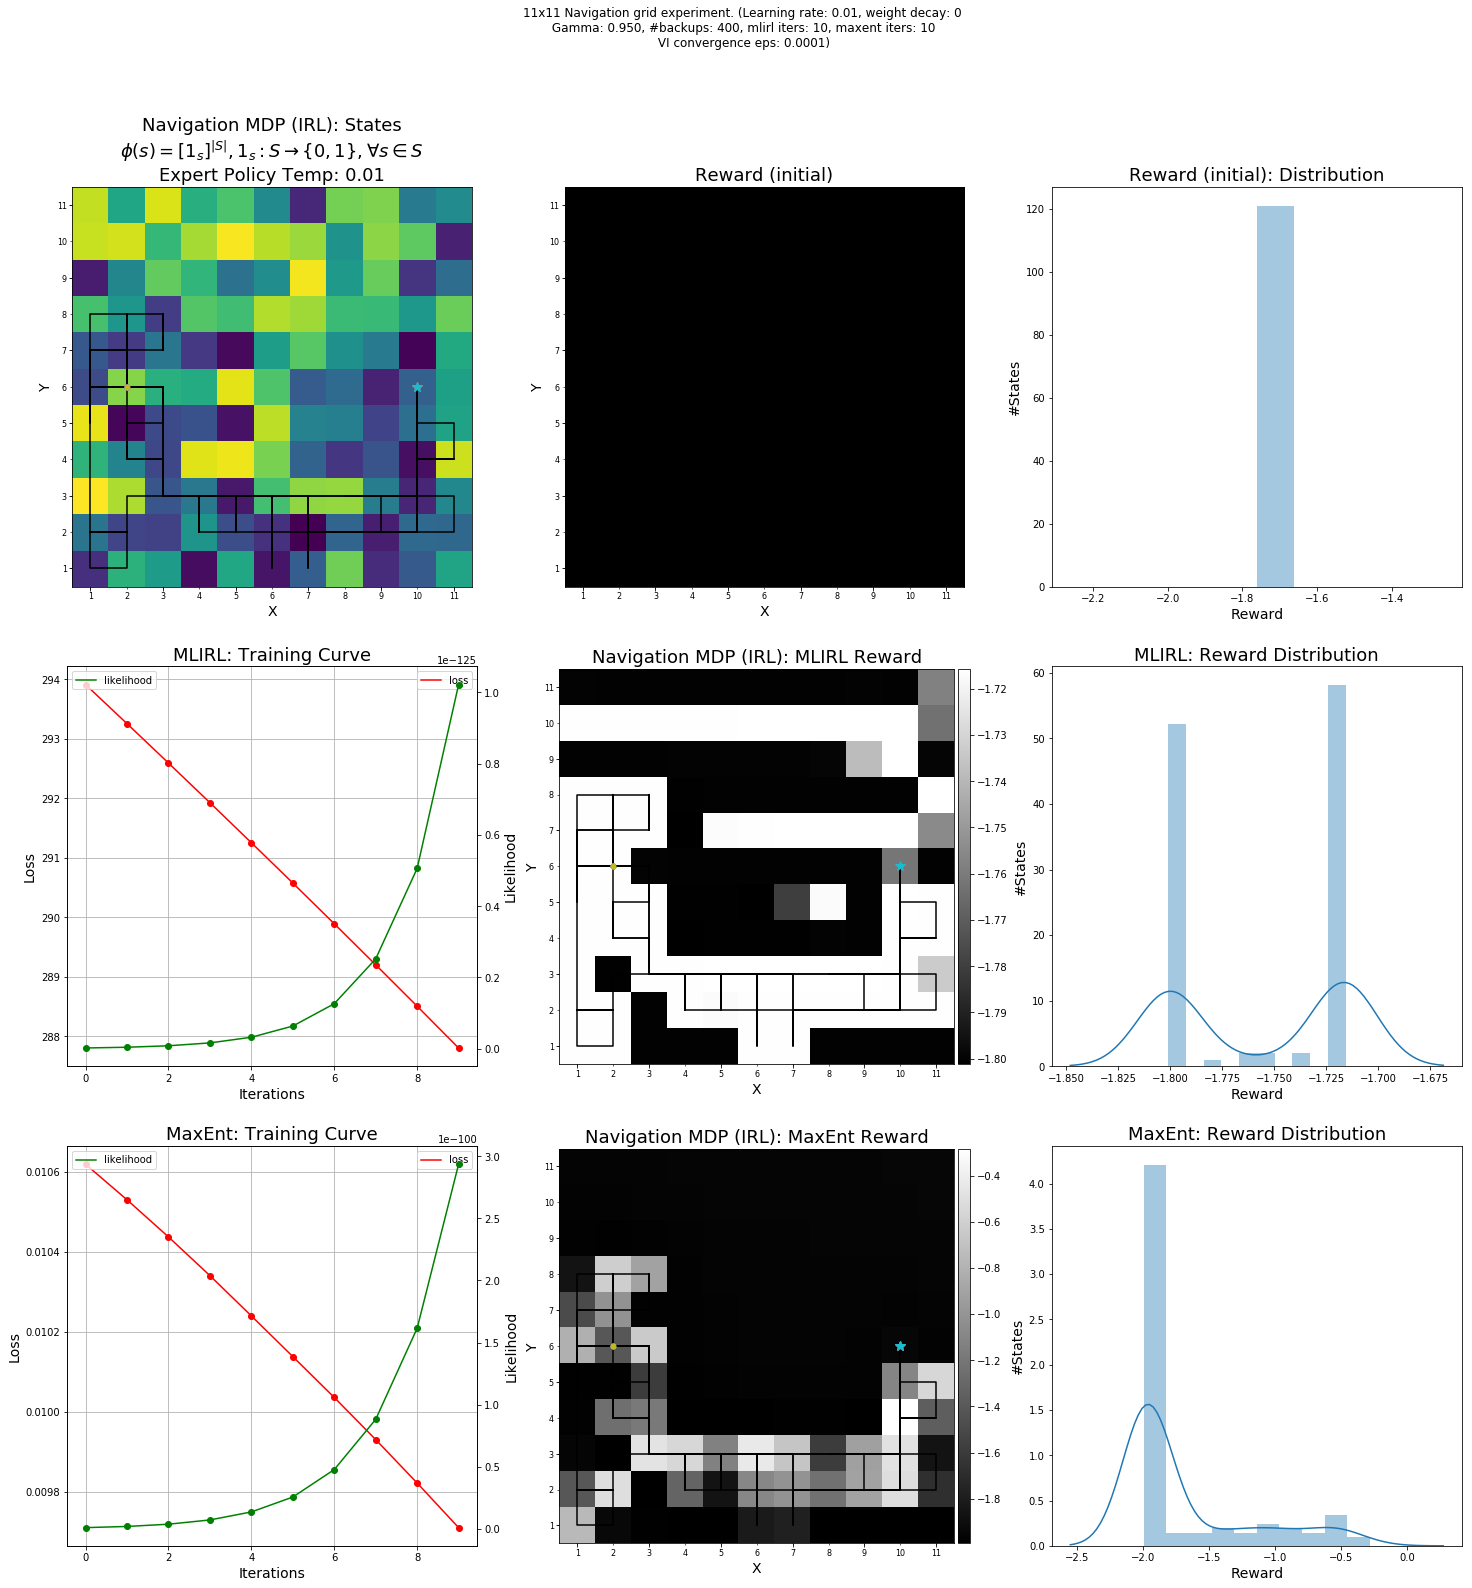

The effect can be more clearly seen in this experiment. The difference from previous one is the size of the grid and higher gamma used for sampling trajectories (which bumped up optimal action probability in farther states and gave bit better trajectories).

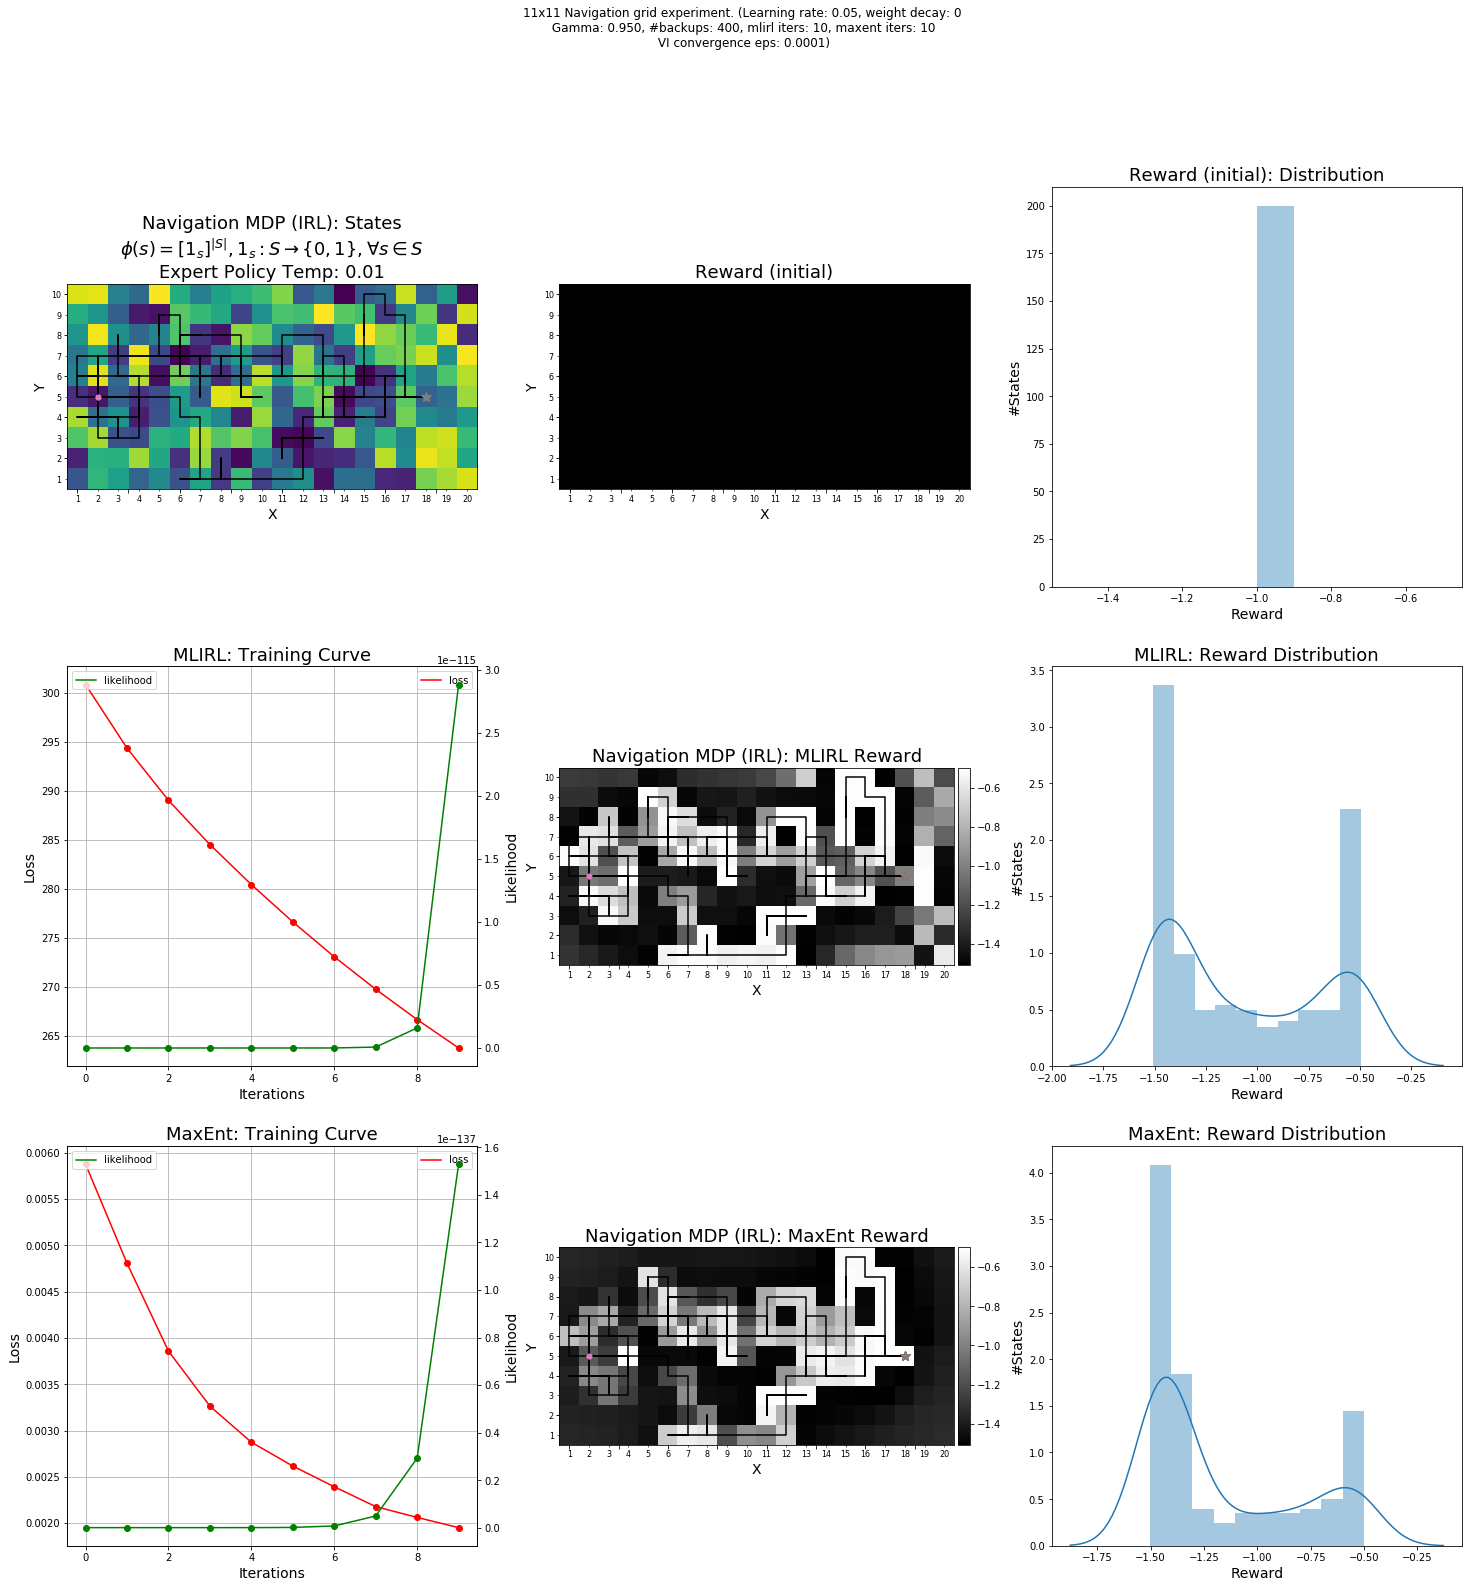

**APR 20-22, 2019**

I ran few experiments. Here’s a brief about first one, few observations, and learning

In the first one, I used the same setup as the previous one; the only major difference was the use of fairly lower learning rate (0.02), longer training iterations (100), and the number of training trajectories (limited to 4).

The reason I used lower learning rate is that VI in MLIRL dies at higher learning rate. At higher learning rate (0.1 and 0.2), MaxEnt had no issue, but MLIRL failed to learn–VI convergence slows with MLIRL iterations and when it takes more than ~200 iterations, the python kernel dies while computing values on my machine.

**I'm assuming it's because maintaining the full computational graph of VI with large iterations exhausts the available RAM (peak usage 6.81 GB before it dies). This needs to be validated.**

I suspected that slow convergence is due to increase in absolute R_max values during training. This could be one more reason to clamp the negative reward value OR use shifted tanh. I designed a small experiment to analyze how VI runtime changes with scale of reward and convergence eps.

Observations: 
- The loss using both algorithms isn't converging in 100 iterations. 
- The variations in trajectories are only due to suboptimality, there's no cost structure in the MDP, all states had the same cost. Any non-positive constant reward function can explain it (e.g., R(s) = 0 or R(s) = -1 for all s in S). The recovered reward function isn't constant. I feel it'd be too strict requirement to expect an algorithm to come up with such reward function. We can expect this from MaxEnt if there was a strong correlation between suboptimality and state features. We can verify this by designing features so that expert demonstrations show preference of some features over the others. 
- The trajectories have cycles, that might be causing some problem in the inference. (This is now resolved using a workaround. For sampling actions, I use the same policy but suppress the probability mass at states where values aren't greater than current value).
- MaxEnt recovered reward distribution is more peaky and varies more smoothly spatially compared to that of MLIRL.

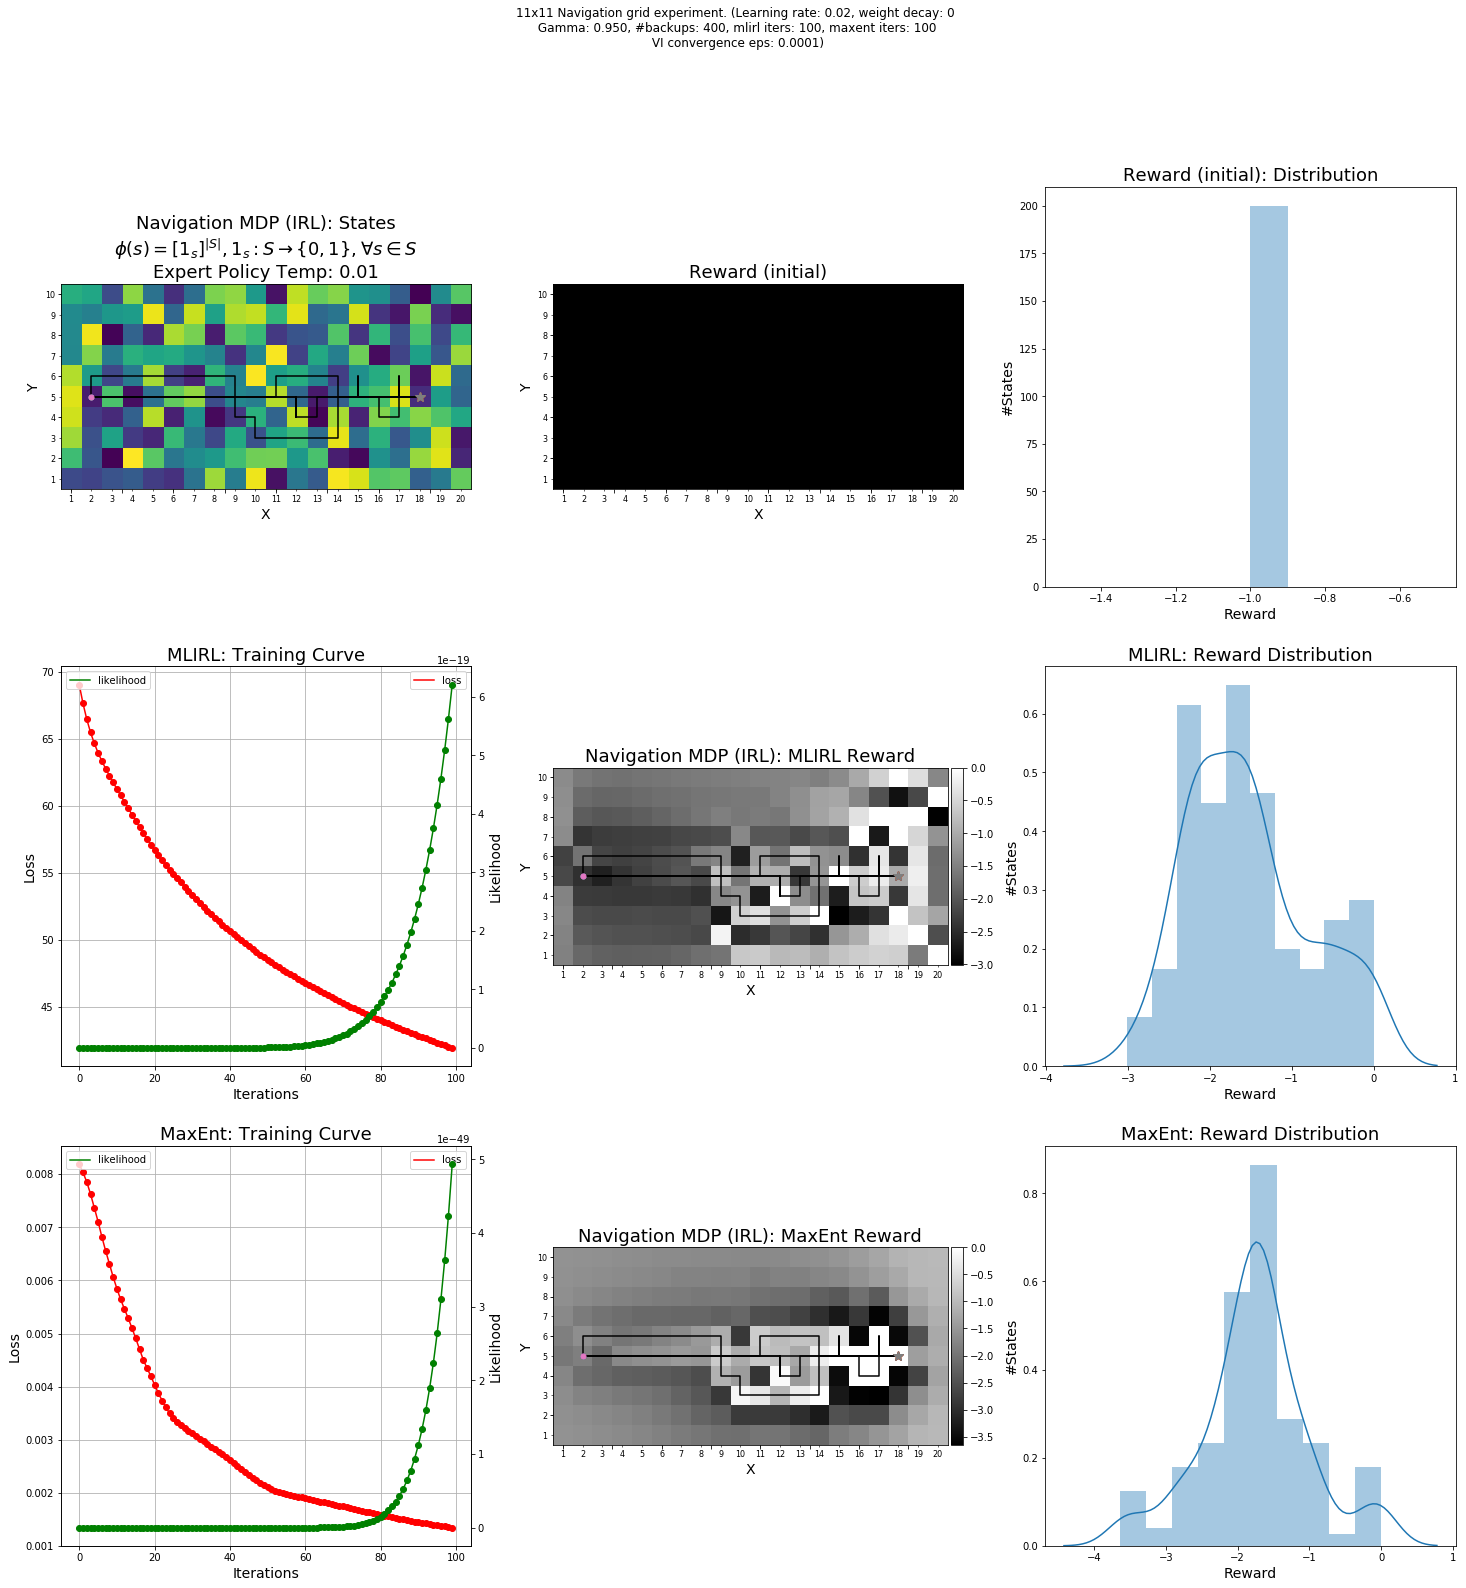

MLIRL  (RELU)
-----
	 Domains: 2, sizes: [384, 384],
	 Action dim: 4, 
	 Feature dim: 384,
	 Iterations: 30, 
	 Max likelihood: 0.99,
	 VI iterations: 400, 
	 VI convergence eps: 0.0001,
	 Gamma (discount factor): 0.95, 
	 Policy example: Q tensor([0.0000, 0.3333, 0.6667, 1.0000]) -> Pi tensor([-1.9547, -1.6213, -1.2880, -0.9547])
Rmax:  tensor(-1., grad_fn=<SelectBackward>)  R min:  tensor(-1., grad_fn=<SelectBackward>)
Running VI [ . ] VI converged @ 56.
Rmax:  tensor(-1., grad_fn=<SelectBackward>)  R min:  tensor(-1., grad_fn=<SelectBackward>)
Running VI [ . ] VI converged @ 56.

>>> Iter: 0000 (34.278s): loss = 33.563114, likelihood = 0.0000


Rmax:  tensor(-0.8000, grad_fn=<SelectBackward>)  R min:  tensor(-1.2000, grad_fn=<SelectBackward>)
Running VI [ . ] VI converged @ 42.
Rmax:  tensor(-0.8000, grad_fn=<SelectBackward>)  R min:  tensor(-1.2000, grad_fn=<SelectBackward>)
Running VI [ . ] VI converged @ 42.

>>> Iter: 0001 (25.628s): loss = 23.814039, likelihood = 0.0000


Rmax:  tensor(-0.6000, grad_fn=<SelectBackward>)  R min:  tensor(-1.4003, grad_fn=<SelectBackward>)
Running VI [ . ] VI converged @ 37.
Rmax:  tensor(-0.6000, grad_fn=<SelectBackward>)  R min:  tensor(-1.4003, grad_fn=<SelectBackward>)
Running VI [ . ] VI converged @ 37.

>>> Iter: 0002 (22.149s): loss = 20.020098, likelihood = 0.0000


Rmax:  tensor(-0.4016, grad_fn=<SelectBackward>)  R min:  tensor(-1.6010, grad_fn=<SelectBackward>)
Running VI [ . ] VI converged @ 38.
Rmax:  tensor(-0.4016, grad_fn=<SelectBackward>)  R min:  tensor(-1.6010, grad_fn=<SelectBackward>)
Running VI [ . ] VI converged @ 38.

>>> Iter: 0003 (22.482s): loss = 18.165333, likelihood = 0.0000


Rmax:  tensor(-0.2124, grad_fn=<SelectBackward>)  R min:  tensor(-1.7991, grad_fn=<SelectBackward>)
Running VI [ . ] VI converged @ 40.
Rmax:  tensor(-0.2124, grad_fn=<SelectBackward>)  R min:  tensor(-1.7991, grad_fn=<SelectBackward>)
Running VI [ . ] VI converged @ 40.

>>> Iter: 0004 (24.118s): loss = 17.109425, likelihood = 0.0000


Rmax:  tensor(-0.0149, grad_fn=<SelectBackward>)  R min:  tensor(-1.9891, grad_fn=<SelectBackward>)
Running VI [ . ] VI converged @ 37.
Rmax:  tensor(-0.0149, grad_fn=<SelectBackward>)  R min:  tensor(-1.9891, grad_fn=<SelectBackward>)
Running VI [ . ] VI converged @ 37.

>>> Iter: 0005 (21.838s): loss = 16.372227, likelihood = 0.0000


Rmax:  tensor(0., grad_fn=<SelectBackward>)  R min:  tensor(-2.1752, grad_fn=<SelectBackward>)
Running VI [ . ] VI converged @ 43.
Rmax:  tensor(0., grad_fn=<SelectBackward>)  R min:  tensor(-2.1752, grad_fn=<SelectBackward>)
Running VI [ . ] VI converged @ 43.

>>> Iter: 0006 (25.027s): loss = 15.762547, likelihood = 0.0000


Rmax:  tensor(0., grad_fn=<SelectBackward>)  R min:  tensor(-2.3673, grad_fn=<SelectBackward>)
Running VI [ . ] VI converged @ 50.
Rmax:  tensor(0., grad_fn=<SelectBackward>)  R min:  tensor(-2.3673, grad_fn=<SelectBackward>)
Running VI [ . ] VI converged @ 50.

>>> Iter: 0007 (29.010s): loss = 15.042503, likelihood = 0.0000


Rmax:  tensor(0., grad_fn=<SelectBackward>)  R min:  tensor(-2.5570, grad_fn=<SelectBackward>)
Running VI [ . ] VI converged @ 57.
Rmax:  tensor(0., grad_fn=<SelectBackward>)  R min:  tensor(-2.5570, grad_fn=<SelectBackward>)
Running VI [ . ] VI converged @ 57.

>>> Iter: 0008 (33.541s): loss = 14.249513, likelihood = 0.0000


Rmax:  tensor(0., grad_fn=<SelectBackward>)  R min:  tensor(-2.7426, grad_fn=<SelectBackward>)
Running VI [ .. ] VI converged @ 67.
Rmax:  tensor(0., grad_fn=<SelectBackward>)  R min:  tensor(-2.7426, grad_fn=<SelectBackward>)
Running VI [ .. ] VI converged @ 67.

>>> Iter: 0009 (39.374s): loss = 13.421551, likelihood = 0.0000


Rmax:  tensor(0., grad_fn=<SelectBackward>)  R min:  tensor(-2.9238, grad_fn=<SelectBackward>)
Running VI [ .. ] VI converged @ 86.
Rmax:  tensor(0., grad_fn=<SelectBackward>)  R min:  tensor(-2.9238, grad_fn=<SelectBackward>)
Running VI [ .. ] VI converged @ 86.

>>> Iter: 0010 (50.745s): loss = 12.575610, likelihood = 0.0000


Rmax:  tensor(0., grad_fn=<SelectBackward>)  R min:  tensor(-3.1008, grad_fn=<SelectBackward>)
Running VI [ ... ] VI converged @ 117.
Rmax:  tensor(0., grad_fn=<SelectBackward>)  R min:  tensor(-3.1008, grad_fn=<SelectBackward>)
Running VI [ ... ] VI converged @ 117.

>>> Iter: 0011 (70.031s): loss = 11.754421, likelihood = 0.0000


Rmax:  tensor(0., grad_fn=<SelectBackward>)  R min:  tensor(-3.2742, grad_fn=<SelectBackward>)
Running VI [ .... ] VI converged @ 123.
Rmax:  tensor(0., grad_fn=<SelectBackward>)  R min:  tensor(-3.2742, grad_fn=<SelectBackward>)
Running VI [ .... ] VI converged @ 123.

>>> Iter: 0012 (75.321s): loss = 11.000984, likelihood = 0.0000


Rmax:  tensor(0., grad_fn=<SelectBackward>)  R min:  tensor(-3.4441, grad_fn=<SelectBackward>)
Running VI [ .... ] VI converged @ 142.
Rmax:  tensor(0., grad_fn=<SelectBackward>)  R min:  tensor(-3.4441, grad_fn=<SelectBackward>)
Running VI [ .... ] VI converged @ 142.

>>> Iter: 0013 (84.473s): loss = 10.319927, likelihood = 0.0000


Rmax:  tensor(0., grad_fn=<SelectBackward>)  R min:  tensor(-3.6106, grad_fn=<SelectBackward>)
Running VI [ ....
    
**---> Kernel Died**


MLIRL (Tanh with -1 bias) 
-----
	 Domains: 2, sizes: [384, 384],
	 Action dim: 4, 
	 Feature dim: 384,
	 Iterations: 30, 
	 Max likelihood: 0.99,
	 VI iterations: 400, 
	 VI convergence eps: 0.0001,
	 Gamma (discount factor): 0.95, 
	 Policy example: Q tensor([0.0000, 0.3333, 0.6667, 1.0000]) -> Pi tensor([-1.9547, -1.6213, -1.2880, -0.9547])
Rmax:  tensor(-1.7616, grad_fn=<SelectBackward>)  R min:  tensor(-1.7616, grad_fn=<SelectBackward>)
Running VI [ . ] VI converged @ 46.
Rmax:  tensor(-1.7616, grad_fn=<SelectBackward>)  R min:  tensor(-1.7616, grad_fn=<SelectBackward>)
Running VI [ . ] VI converged @ 46.

>>> Iter: 0000 (28.817s): loss = 31.773748, likelihood = 0.0000


Rmax:  tensor(-1.6640, grad_fn=<SelectBackward>)  R min:  tensor(-1.8337, grad_fn=<SelectBackward>)
Running VI [ . ] VI converged @ 50.
Rmax:  tensor(-1.6640, grad_fn=<SelectBackward>)  R min:  tensor(-1.8337, grad_fn=<SelectBackward>)
Running VI [ . ] VI converged @ 50.

>>> Iter: 0001 (30.271s): loss = 26.240675, likelihood = 0.0000


Rmax:  tensor(-1.5369, grad_fn=<SelectBackward>)  R min:  tensor(-1.8854, grad_fn=<SelectBackward>)
Running VI [ . ] VI converged @ 39.
Rmax:  tensor(-1.5369, grad_fn=<SelectBackward>)  R min:  tensor(-1.8854, grad_fn=<SelectBackward>)
Running VI [ . ] VI converged @ 39.

>>> Iter: 0002 (25.029s): loss = 21.362635, likelihood = 0.0000


Rmax:  tensor(-1.3792, grad_fn=<SelectBackward>)  R min:  tensor(-1.9218, grad_fn=<SelectBackward>)
Running VI [ . ] VI converged @ 57.
Rmax:  tensor(-1.3792, grad_fn=<SelectBackward>)  R min:  tensor(-1.9218, grad_fn=<SelectBackward>)
Running VI [ . ] VI converged @ 57.

>>> Iter: 0003 (34.934s): loss = 18.402935, likelihood = 0.0000


Rmax:  tensor(-1.1956, grad_fn=<SelectBackward>)  R min:  tensor(-1.9469, grad_fn=<SelectBackward>)
Running VI [ ........ ] VI converged @ 249.
Rmax:  tensor(-1.1956, grad_fn=<SelectBackward>)  R min:  tensor(-1.9469, grad_fn=<SelectBackward>)
Running VI [ ........ ] VI converged @ 249.

>>> Iter: 0004 (174.345s): loss = 16.668770, likelihood = 0.0000


Rmax:  tensor(-0.9962, grad_fn=<SelectBackward>)  R min:  tensor(-1.9639, grad_fn=<SelectBackward>)
Running VI [ ..
    
**---> Kernel Died**

It appears that convergence rate grows linearly (or some big-oh of log linear) with increase in scale, and grows exponentially with decrease in convergence eps.

We’ve set V(goal) to 0 which is also V_max, but the V_min is free–we don’t have any constraint yet. So the value has upper bound, but lower bound is free. With free lower bound, reasoning might slow down because it’ll always be possible to assign higher costs to states as long as max possible likelihood (1.0) is not achieved.

For optimal behavior, it might work, but when there’s sub-optimality, we can’t achieve maximum possible likelihood. For example, if we have two paths that are equally preferable, the highest likelihood we can get is 0.5. In such situation, we’d always have gradient flowing in the system, and value distribution keeps on shifting towards negative direction over each IRL iteration. Such indecisiveness about lowest possible cost could dramatically slow down the convergence.

It appears that i’d be useful to also force V_min to some value. The scale of reward to be used for better convergence seems to be related with discount rate and value convergence threshold (because worst case (lowest) values are simply sum of discounted R_min).

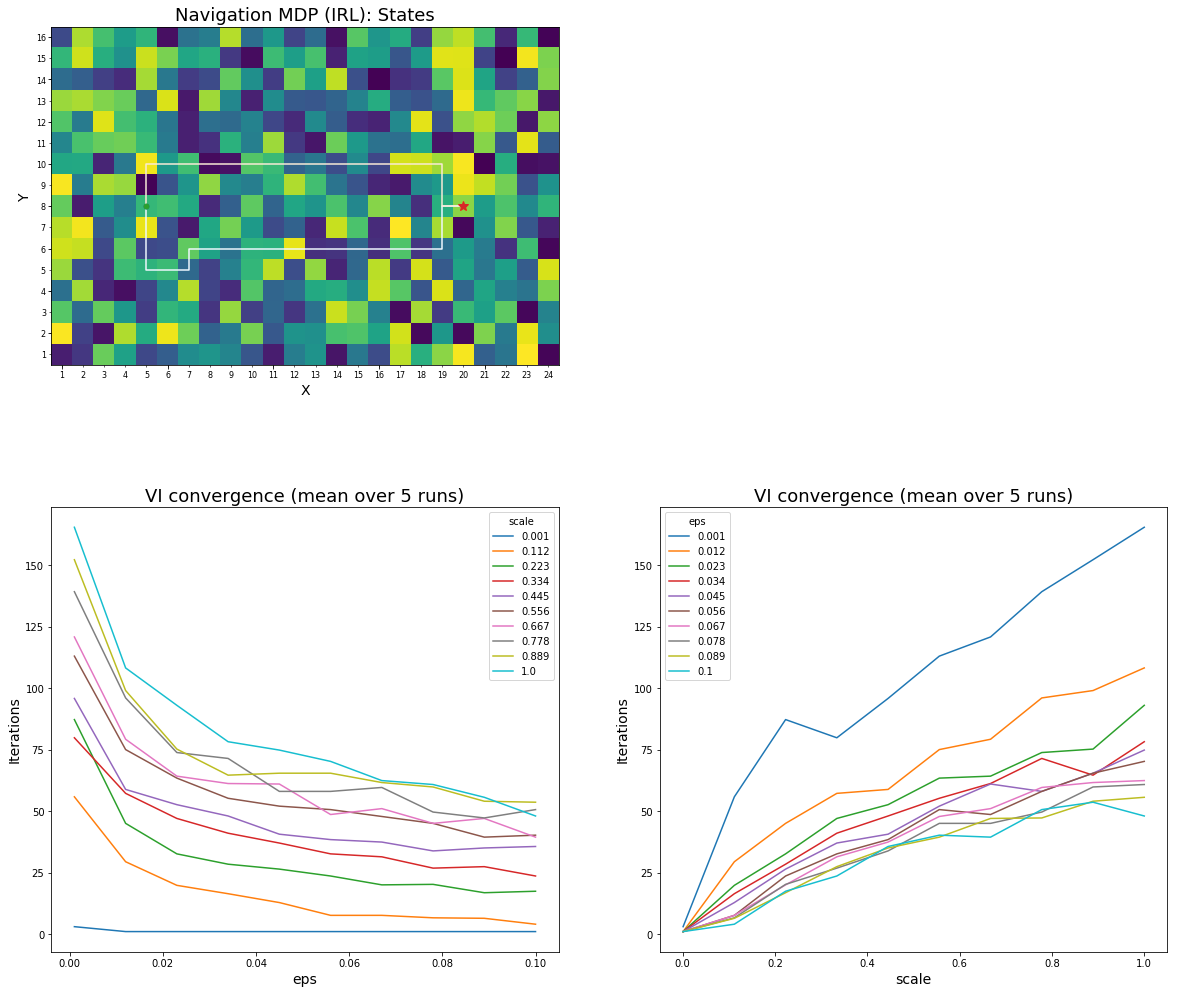

In the second experiment, I used only 1 trajectory to see how that works out. 

Observations:
- MaxEnt and MLIRL recover quite similar reward values for plausible obstacle states. The obstacles aren't actually there in the original MDP from which trajectories were sampled, they're imagined to explain the suboptimal decisions. 
- Because we only have 1 trajectory and orthogonal feature space, we can't expect good generalization as well as counterfactual reasoning (cancelling out differences in inferred credit from reasoning over different trajectories).
- In inferred obstacles states, we see cost function changing smoothly. In MLIRL, I think the smooth nature is due to credit assignment (diminishing gradient effect). Whereas in MaxEnt, I believe it's because 1) learner's SVF diminishes each step (for all states on subiptimal paths), and 2) the reward gradient is proportional to SVF difference. dLoss / dtheta = dLoss / dR * dR / dtheta, where dLoss is SVF difference (Ref: MaxEnt proofs). SVF of expert is 0 on all unvisted states, and learner's SVF changes smoothly with distance from initial states, that's why I think we see smoothly varying reward function.

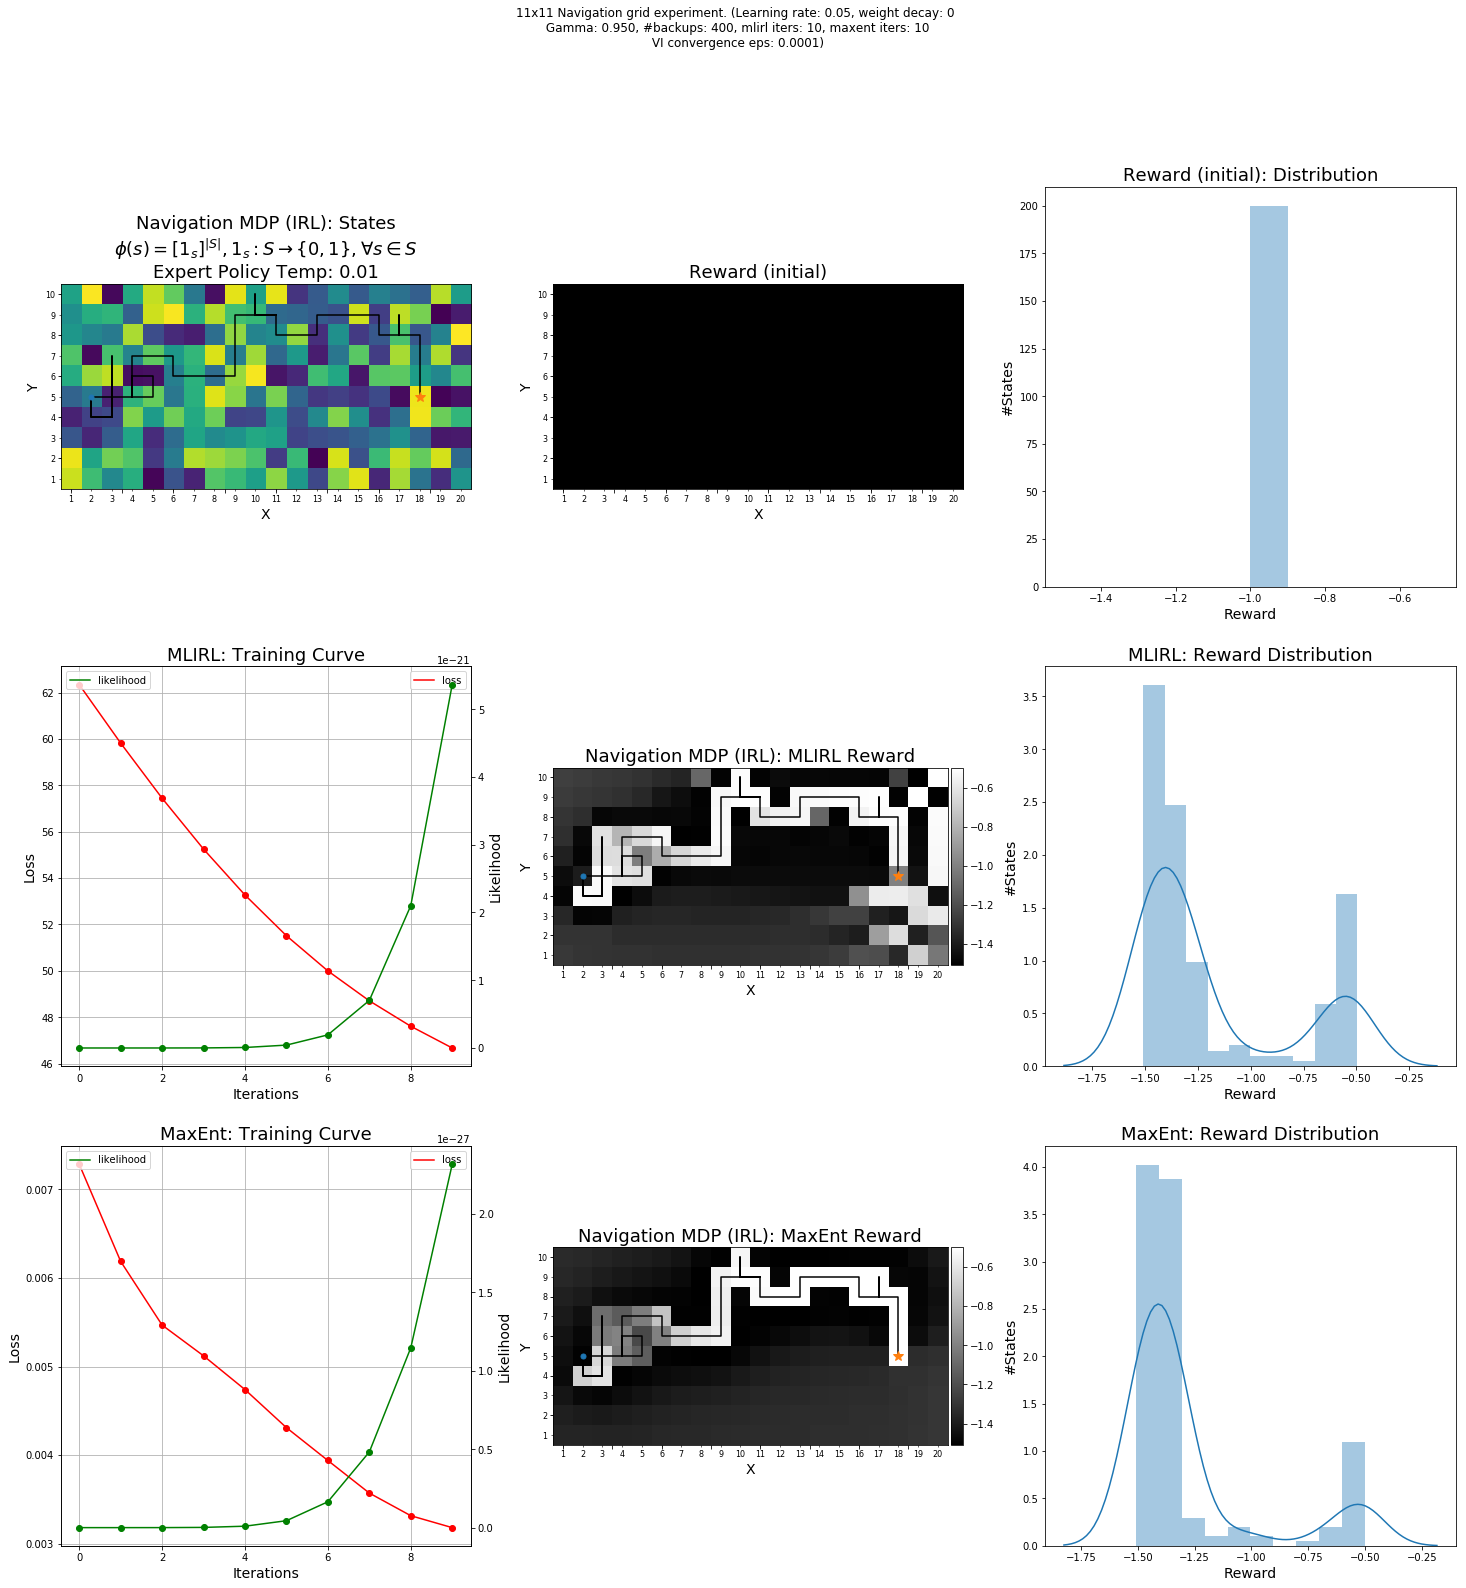

**Not convergence could also mean path not ending in the goal or there's high uncertainty so values keep fluctuating.**

In third experiment, I used trajectories with no cycles (fixed trajectory sampling algo). The experiment was run for 30 iterations.

We see interesting patterns, the MLIRL patterns are much more weird than the MaxEnt ones. I suspect it could be credit bouncing off the walls and forming a pattern like standing waves. I don't know, need to validate this.

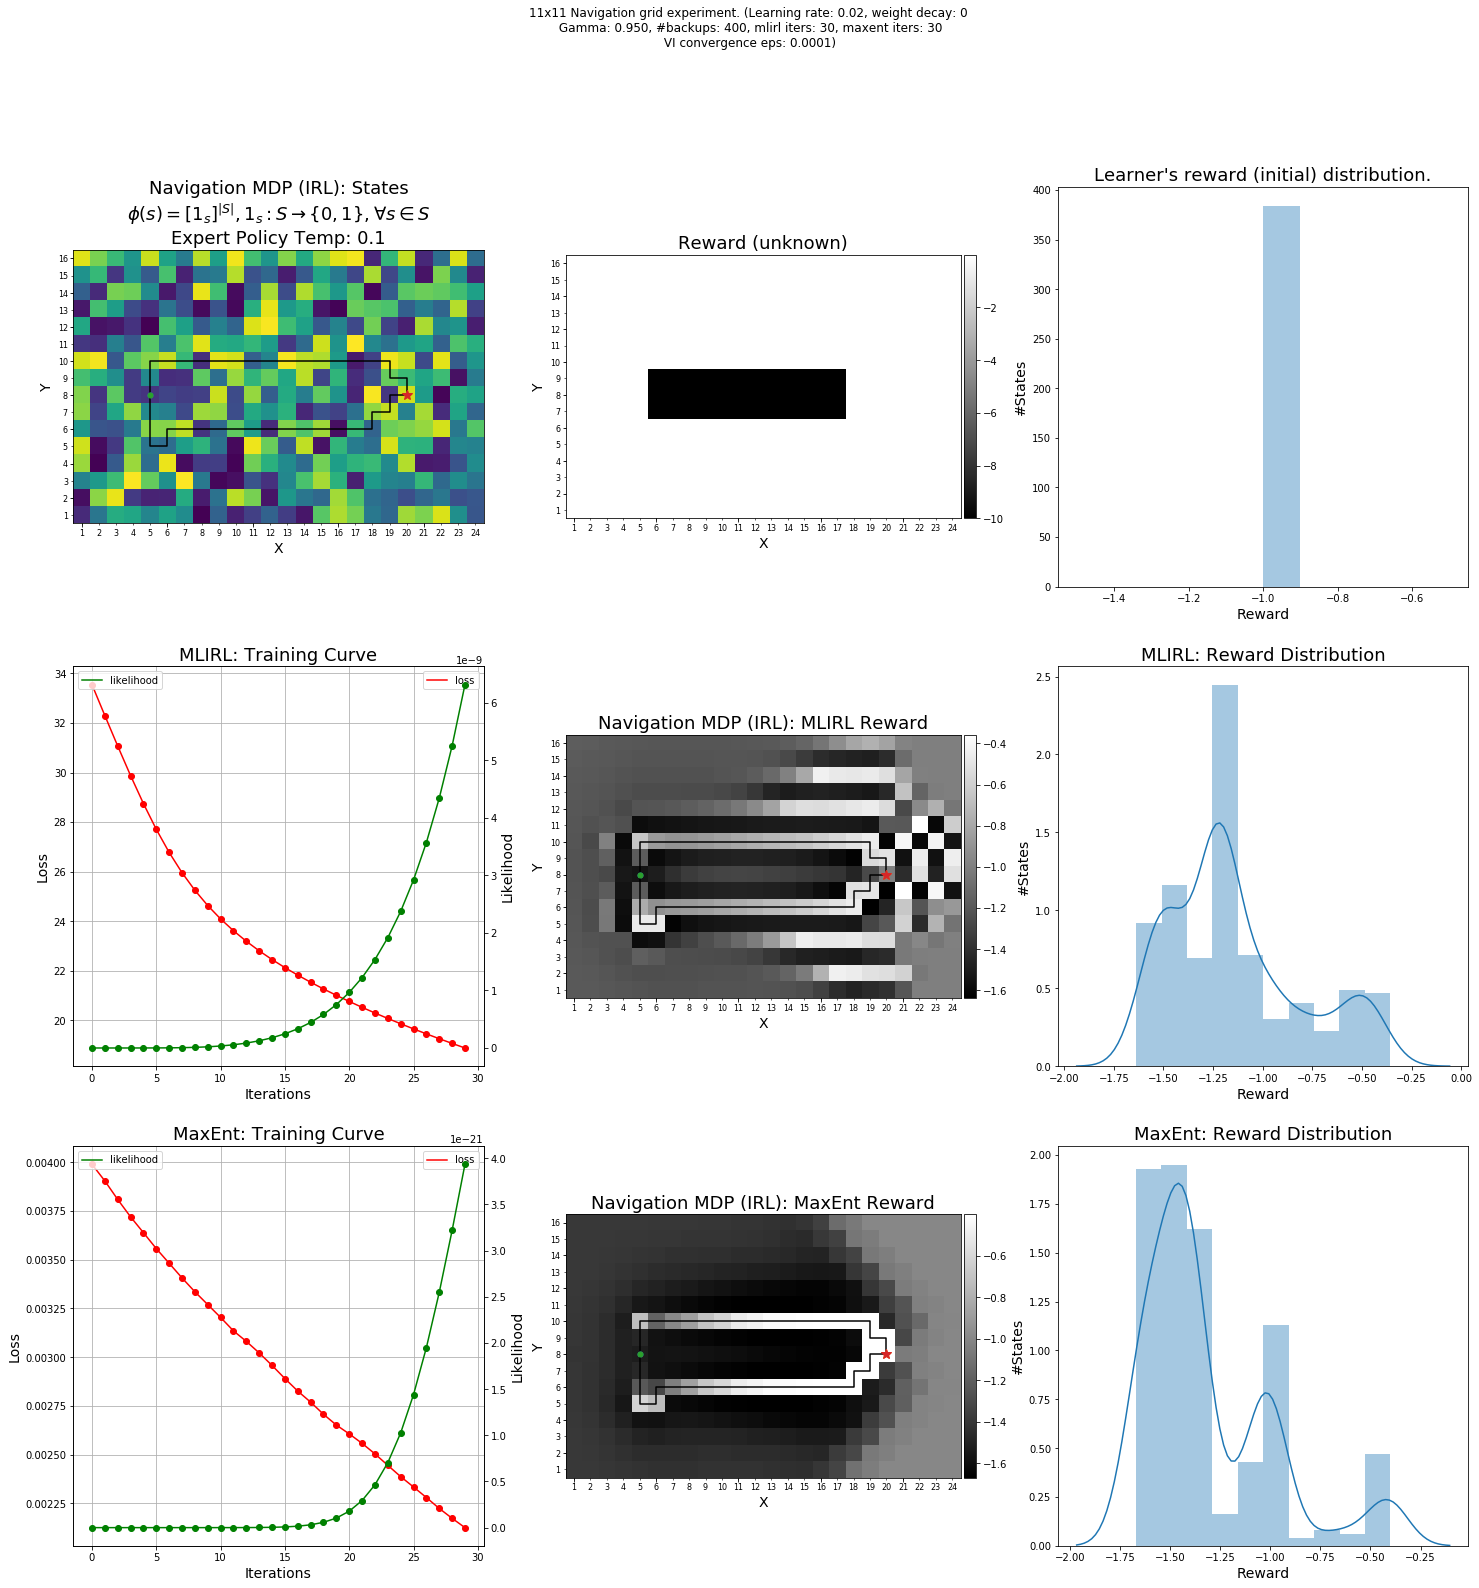

**If slope of Tanh is too steep, it could throw reward values in saturation region and loss will stop improving.**

**Squaring the reward, negating, and shifting it won't ever have reward values operating in saturation region. ReLU, Tanh, or no operator is better than squaring. Squaring is like using if. Other operators are blind about the sign, so no matter what we will use, there are input values that will be mapped to saturation region.**

I just learned something about activation function. You had recommended long ago but I couldn’t understand that it was like a necessary thing. 

To get non-positive, never saturating reward values, we must use “squaring” like operators. Squaring reward values and then negating them won’t ever have reward values operating in saturation region except at a point 0.  Squaring uses “if” logic implicitly–if values are negative the sign changes otherwise not. In addition, we could use all the benefits that come with zero centering the inputs/activations in neural networks. “Absolute” does the same thing, the only small issue is that it’s not differentiable at 0. 

Operators like ReLU, Tanh, and ELU are blind about the sign; there will always be a range of input values operating in a saturation region, so if during learning some states have a reward in these regions they’ll stop improving. We can manipulate with the input values so that we get desired behavior, but that will require inputs/activations distribution that’s not zero centered. So it seems operators like ReLU and Tanh aren’t better over “squaring” and “absolute” for linear regression.

To limit the R_max (or R_min) for faster convergence, we can maybe use ReLU or Tanh on top of squared values.

This will still have saturation regions, but we can minimize the adverse effects of it by using low enough learning rate. The key property is symmetricity over positive and negative input values, so that the input/activation distribution can stay zero centered without hurting the performance. (edited)

**I think it's important to run VI until convergence, and then reason. The paths of credit and blame would be weird if we don't do it.**

Counter: We want to go from R to Pi and backpropr from Pi to R. The process that let us go from R to Pi is VI, if we don't use it we lose that information. What was important in the short horizon and how the beliefs change over iterations. 

Reasoning with VI: gradients flow longer term path plus shorter term path, mangitude of each depending on the horizon. The larger the horizon the larger the magintude, the low horizon valuess get feedback scaled down by gamma for each time step in past. 

**How to aggregate all the credits and blames and reason with less noisy input?**